# 0. Imports & Functions
CMM: removed redundant and unused imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os
import io
import re
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GroupKFold
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import torch
from ABRA_35.models import interpolate_and_smooth, CNN

warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
filter1 = 128
filter2 = 32
dropout1 = 0.5
dropout2 = 0.3
dropout_fc = 0.1

# Model initialization
peak_finding_model = CNN(filter1, filter2, dropout1, dropout2, dropout_fc)
model_loader = torch.load('./ABRA_35/models/waveI_cnn.pth')
peak_finding_model.load_state_dict(model_loader)
peak_finding_model.eval()

def peak_finding(wave):
    # Prepare waveform
    waveform=interpolate_and_smooth(wave) # Added indexing per calculate and plot wave function
    # waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0) archived ABRA
    waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).unsqueeze(0) #newer ABRA
    # print(waveform_torch)
    # Get prediction from model
    outputs = peak_finding_model(waveform_torch)
    prediction = int(round(outputs.detach().numpy()[0][0], 0))
    # prediction_test = int(round(outputs.detach().numpy()[0], 0))
    # print("Model output:", outputs, "Prediction true start:", prediction)

    # Apply Gaussian smoothing
    smoothed_waveform = gaussian_filter1d(waveform, sigma=1)

    # Find peaks and troughs
    n = 18
    t = 14
    # start_point = prediction - 9 archived ABRA
    start_point = prediction - 6 #newer ABRA
    smoothed_peaks, _ = find_peaks(smoothed_waveform[start_point:], distance=n)
    smoothed_troughs, _ = find_peaks(-smoothed_waveform, distance=t)
    sorted_indices = np.argsort(smoothed_waveform[smoothed_peaks+start_point])
    highest_smoothed_peaks = np.sort(smoothed_peaks[sorted_indices[-5:]] + start_point)
    relevant_troughs = np.array([])
    for p in range(len(highest_smoothed_peaks)):
        c = 0
        for t in smoothed_troughs:
            if t > highest_smoothed_peaks[p]:
                if p != 4:
                    try:
                        if t < highest_smoothed_peaks[p+1]:
                            relevant_troughs = np.append(relevant_troughs, int(t))
                            break
                    except IndexError:
                        pass
                else:
                    relevant_troughs = np.append(relevant_troughs, int(t))
                    break
    relevant_troughs = relevant_troughs.astype('i')
    return highest_smoothed_peaks, relevant_troughs

def extract_metadata(metadata_lines):
    # Dictionary to store extracted metadata
    metadata = {}
    
    for line in metadata_lines:
        # Extract SW FREQ
        freq_match = re.search(r'SW FREQ:\s*(\d+\.?\d*)', line)
        if freq_match:
            metadata['SW_FREQ'] = float(freq_match.group(1))
        
        # Extract LEVELS
        levels_match = re.search(r':LEVELS:\s*([^:]+)', line)
        if levels_match:
            # Split levels and convert to list of floats
            metadata['LEVELS'] = [float(level) for level in levels_match.group(1).split(';') if level]
    
    return metadata

def read_custom_tsv(file_path):
    # Read the entire file
    with open(file_path, 'r', encoding='ISO-8859-1') as f:
        content = f.read()
    
    # Split the content into metadata and data sections
    metadata_lines = []
    data_section = None
    
    # Find the ':DATA' marker
    data_start = content.find(':DATA')
    
    if data_start != -1:
        # Extract metadata (lines before ':DATA')
        metadata_lines = content[:data_start].split('\n')
        
        # Extract data section
        data_section = content[data_start:].split(':DATA')[1].strip()
    
    # Extract specific metadata
    metadata = extract_metadata(metadata_lines)
    
    # Read the data section directly
    try:
        # Use StringIO to create a file-like object from the data section
        raw_data = pd.read_csv(
            io.StringIO(data_section), 
            sep='\s+',  # Use whitespace as separator
            header=None
        )
        raw_data = raw_data.T
        # Add metadata columns to the DataFrame
        if 'SW_FREQ' in metadata:
            raw_data['Freq(kHz)'] = metadata['SW_FREQ']
            # raw_data['Freq(Hz)'] = raw_data['Freq(Hz)'].apply(lambda x: x*1000)
        
        if 'LEVELS' in metadata:
            # Repeat levels to match the number of rows
            levels_repeated = metadata['LEVELS'] * (len(raw_data) // len(metadata['LEVELS']) + 1)
            raw_data['Level(dB)'] = levels_repeated[:len(raw_data)]
        
        filtered_data = raw_data.apply(pd.to_numeric, errors='coerce').dropna()
        filtered_data.columns = filtered_data.columns.map(str)

        columns = ['Freq(kHz)'] + ['Level(dB)'] + [col for col in filtered_data.columns if col.isnumeric() == True]
        filtered_data = filtered_data[columns]
        return filtered_data
    
    except Exception as e:
        print(f"Error reading data: {e}")
        return None, metadata

In [3]:
def peaks_troughs_amp_final(df, freq, db, time_scale=10, multiply_y_factor=1.0, units='Microvolts'):
    db_column = 'Level(dB)'
    
    khz = df[(df['Freq(kHz)'] == freq) & (df[db_column] == db)]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        # Process the wave as in calculate_and_plot_wave
        y_values = interpolate_and_smooth(final, target)
        
        # Apply scaling factor
        y_values *= multiply_y_factor
        
        # Handle units conversion if needed
        if units == 'Nanovolts':
            y_values /= 1000
            
        # Generate normalized version for peak finding
        y_values_fpf = interpolate_and_smooth(y_values[:244])
        
        # Standardize and normalize for peak finding, exactly as in the original
        flattened_data = np.array(y_values_fpf).flatten().reshape(-1, 1)
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(flattened_data)
        min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = min_max_scaler.fit_transform(standardized_data).reshape(y_values_fpf.shape)
        y_values_fpf = interpolate_and_smooth(scaled_data[:244])
        
        # Find peaks using the normalized data
        highest_peaks, relevant_troughs = peak_finding(y_values_fpf)
        
        # Calculate amplitude on the processed but non-normalized data
        if highest_peaks.size > 0 and relevant_troughs.size > 0:
            # Following the same approach as in the display_metrics_table function
            first_peak_amplitude = y_values[highest_peaks[0]] - y_values[relevant_troughs[0]]
            return highest_peaks, relevant_troughs, first_peak_amplitude
    
    return None, None, None

# 1. Data Processing

In [4]:
# del int
time_scale = 18
amp_per_freq = {'Subject': [], 'Freq(kHz) (x1)': [], 'Level(dB) (x2)': [], 'Amplitude (x3)':[]}
start_path = '../liberman_wpz/WPZ Electrophysiology'
for subject in os.listdir(start_path):
    if not os.path.isdir(os.path.join(start_path,subject)):
        continue
    for fq in os.listdir(os.path.join(start_path,subject)):
        # print(fq)
        if fq.startswith('ABR') and fq.endswith('.tsv'):
            path = os.path.join(start_path,subject,fq)
            data_df = read_custom_tsv(path)
            # print(data_df)
            freqs = data_df['Freq(kHz)'].unique().tolist()
            levels = data_df['Level(dB)'].unique().tolist()
            for freq in freqs:
                for lvl in levels:
                    # print("Frequency=",freq, "Level=", lvl)
                    _, _, amp = peaks_troughs_amp_final(df=data_df, freq=freq, db=lvl, time_scale=time_scale)
                    # print(f'Amplitude: {amp}\n')
                    amp_per_freq['Subject'].append(subject)
                    amp_per_freq['Freq(kHz) (x1)'].append(freq)
                    amp_per_freq['Level(dB) (x2)'].append(lvl)
                    amp_per_freq['Amplitude (x3)'].append(amp)
        else:
            pass


amp_df_full = pd.DataFrame(data=amp_per_freq)


In [5]:
raw_synapse_counts = pd.read_excel('../liberman_wpz/WPZ Ribbon and Synapse Counts.xlsx')
raw_synapse_counts = raw_synapse_counts.mask(lambda x: x.isnull()).dropna()
raw_synapse_counts['Synapses to IHC (y1)'] = raw_synapse_counts.iloc[:,6]
raw_synapse_counts['vx (x4)'] = raw_synapse_counts['vx']
raw_synapse_counts.drop(columns=['vx'], inplace=True)
raw_synapse_counts.rename(columns={'Freq':'Freq(kHz) (x1)'}, inplace=True)
# raw_synapse_counts['Freq(Hz) (x1)'] = raw_synapse_counts['Freq(Hz) (x1)'].apply(lambda x: x*1000) # PUTTING BACK
raw_synapse_counts.rename(columns={'Case':'Subject'}, inplace=True)

In [6]:
stats = raw_synapse_counts[['Subject', 'Freq(kHz) (x1)', 'Synapses to IHC (y1)']].groupby(['Subject', 'Freq(kHz) (x1)']).agg(
	mean=('Synapses to IHC (y1)', 'mean'),
	diff=('Synapses to IHC (y1)', lambda x: x.max() - x.min())
)

In [7]:
# Version 1 - values per vx

paired = amp_df_full.join(raw_synapse_counts.set_index(['Subject', 'Freq(kHz) (x1)']), on=['Subject', 'Freq(kHz) (x1)'])
# slice = paired[paired['Subject']=='WPZ174'][['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs (y2)']]
final = paired[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs']]
final_clean = final.dropna()

# adding in the strain feature
strains = pd.read_excel('../liberman_wpz/WPZ Mouse groups.xlsx')
final_clean_strained = final_clean.join(strains.set_index('ID#'), on='Subject')
final_clean_strained['Strain'] = final_clean_strained['Strain'].str.strip()
final_clean_strained = final_clean_strained.rename(columns={'Strain': 'Strain (x5)'})
final_clean_strained = final_clean_strained.dropna()
final_clean_strained = final_clean_strained[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Synapses to IHC (y1)', 'Group']]

final_clean_strained_grouped = final_clean_strained.copy()
final_clean_strained_grouped['Group - dB'] = final_clean_strained_grouped['Group'].apply(lambda x: x.split(' ')[0] if x.split(' ')[0].endswith('dB') else 'Control')
final_clean_strained_grouped['Group - Time Elapsed'] = final_clean_strained_grouped['Group'].apply(lambda x: x.split(' ')[1] if x.split(' ')[1].endswith(('h', 'wks', 'w')) else x.split(' ')[0])
final_clean_strained_grouped.head()

final_clean_strained_grouped_pos = final_clean_strained_grouped.copy()
final_clean_strained_grouped_pos['Amplitude (x3)'] = final_clean_strained_grouped['Amplitude (x3)'].apply(lambda x: 0 if x < 0 else x)

final_clean_strained_grouped_pos_cleangroup = final_clean_strained_grouped_pos.copy()
final_clean_strained_grouped_pos_cleangroup['Group'] = final_clean_strained_grouped_pos_cleangroup['Group'].apply(lambda x: x.strip())

final_clean_strained_grouped_pos_cleangroup.head()
final_clean_strained_grouped_pos_cleangroup_vs = final_clean_strained_grouped_pos_cleangroup.copy()
final_clean_strained_grouped_pos_cleangroup_vs['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - dB']
# final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed']
final_clean_strained_grouped_pos_cleangroup_vs = final_clean_strained_grouped_pos_cleangroup_vs[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)',
       'vx (x4)', 'Strain (x5)','Group - dB (x6)', 'Group - Time Elapsed', 'Group','Synapses to IHC (y1)']]

def split_on_number(input_string):
    return re.findall(r"[A-Za-z]+|\d+", input_string)

hrs_week = 24*7

final_clean_strained_grouped_pos_cleangroup_vs_timed = final_clean_strained_grouped_pos_cleangroup_vs.copy()
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: '0dB' if x == 'Control' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'].apply(lambda x: x[1])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'].apply(lambda x: "wks" if x == 'w' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Hours Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed.apply(lambda row: row['Group - Time Elapsed - Magn.']* hrs_week if row['Group - Time Elapsed - Unit'] == 'wks' else row['Group - Time Elapsed - Magn.'], axis = 1)

In [8]:
# Version 2 - Averaged per Vx

paired2 = amp_df_full.join(raw_synapse_counts.set_index(['Subject', 'Freq(kHz) (x1)']), on=['Subject', 'Freq(kHz) (x1)'])
# lilslice = paired[paired['Subject']=='WPZ174'][['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs']]
final2 = paired2[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'Synapses', 'IHCs']]
final_clean2 = final2.dropna()

# adding in the strain feature
#strains = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Mouse groups.xlsx')
final_clean_strained2 = final_clean2.join(strains.set_index('ID#'), on='Subject')
final_clean_strained2['Strain'] = final_clean_strained2['Strain'].str.strip()
final_clean_strained2 = final_clean_strained2.rename(columns={'Strain': 'Strain (x5)'})
final_clean_strained2 = final_clean_strained2.dropna()
final_clean_strained2 = final_clean_strained2[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Synapses to IHC (y1)', 'Group', 'Synapses', 'IHCs']]
# np.unique(final_clean_strained2['Group'])

# final_clean_70 = final_clean[final_clean['Level(dB) (x2)'] >= 70.0]
# final_clean_strained_70 = final_clean_strained[final_clean_strained['Level(dB) (x2)'] >= 70.0]
# # np.unique(final_clean['Level(dB) (x2)']) max level is 80 db
# len(final_clean), len(final_clean_70) # 10000 less data points!!!

final_clean_strained_grouped2 = final_clean_strained2.copy()
final_clean_strained_grouped2['Group - dB'] = final_clean_strained_grouped2['Group'].apply(lambda x: x.split(' ')[0] if x.split(' ')[0].endswith('dB') else 'Control')
final_clean_strained_grouped2['Group - Time Elapsed'] = final_clean_strained_grouped2['Group'].apply(lambda x: x.split(' ')[1] if x.split(' ')[1].endswith(('h', 'wks', 'w')) else x.split(' ')[0])
final_clean_strained_grouped2.head()

final_clean_strained_grouped_pos2 = final_clean_strained_grouped2.copy()
final_clean_strained_grouped_pos2['Amplitude (x3)'] = final_clean_strained_grouped2['Amplitude (x3)'].apply(lambda x: 0 if x < 0 else x)

len(final_clean_strained_grouped_pos2[final_clean_strained_grouped_pos2['Amplitude (x3)'] < 0])

final_clean_strained_grouped_pos2['Amplitude (x3)'] = final_clean_strained_grouped2['Amplitude (x3)'].apply(lambda x: 0 if x < 0 else x)

# final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Subject'] == 'WPZ66') & (final_clean_strained_grouped_pos['Amplitude (x3)'] ==0.055901451434921576)
final_clean_strained_grouped_pos_cleangroup2 = final_clean_strained_grouped_pos2.copy()
final_clean_strained_grouped_pos_cleangroup2['Group'] = final_clean_strained_grouped_pos_cleangroup2['Group'].apply(lambda x: x.strip())
np.unique(final_clean_strained_grouped_pos_cleangroup2['Group'])

final_clean_strained_grouped_pos_cleangroup2.head()
final_clean_strained_grouped_pos_cleangroup_vs2 = final_clean_strained_grouped_pos_cleangroup2.copy()
final_clean_strained_grouped_pos_cleangroup_vs2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs2['Group - dB']
# final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed']
final_clean_strained_grouped_pos_cleangroup_vs2 = final_clean_strained_grouped_pos_cleangroup_vs2[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)',
       'vx (x4)', 'Strain (x5)','Group - dB (x6)', 'Group - Time Elapsed', 'Group','Synapses to IHC (y1)', 'Synapses', 'IHCs']]

def split_on_number(input_string):
    return re.findall(r"[A-Za-z]+|\d+", input_string)

hrs_week = 24*7

final_clean_strained_grouped_pos_cleangroup_vs_timed2 = final_clean_strained_grouped_pos_cleangroup_vs2.copy()
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(lambda x: '0dB' if x == 'Control' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Split'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Split'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Magn.'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Split'].apply(lambda x: x[1])
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Unit'].apply(lambda x: "wks" if x == 'w' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Hours Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2.apply(lambda row: row['Group - Time Elapsed - Magn.']* hrs_week if row['Group - Time Elapsed - Unit'] == 'wks' else row['Group - Time Elapsed - Magn.'], axis = 1)
final_clean_strained_grouped_pos_cleangroup_vs_timed2

freqs = np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2['Freq(kHz) (x1)'])
subs = np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2['Subject'])
final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx = final_clean_strained_grouped_pos_cleangroup_vs_timed2.copy()
for freq in freqs:
    for sub in subs:
        mask = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)] # global for updates
        if len(mask) > 0:

            mask1 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['vx (x4)'] == 'v1')]
            mask2 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['vx (x4)'] == 'v2')]

            if not mask1.empty and not mask2.empty:
                mask1 = mask1.reset_index().iloc[0,:]
                mask2 = mask2.reset_index().iloc[0,:]

                total_syns = float(mask1['Synapses'] + mask2['Synapses'])
                total_ihcs = float(mask1['IHCs'] + mask2['IHCs'])
                ratio = total_syns / total_ihcs
                # print(total_syns, total_ihcs)
                # if total_syns == 0.0 or total_ihcs == 0.0:
                #     print(sub, freq)
                mask_index = mask.index
                final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[mask_index,'Synapse to IHC Ratio per Freq (y2)'] = ratio

final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Synapse to IHC Ratio per Freq (y2)']

0        9.831461
0        9.831461
1        9.831461
1        9.831461
2        9.831461
          ...    
7328    16.170213
7329    16.170213
7329    16.170213
7330    16.170213
7330    16.170213
Name: Synapse to IHC Ratio per Freq (y2), Length: 12187, dtype: float64

# 2. Bayesian Model

In [9]:
class BayesianProfile_LRcompare_strain:
    def __init__(self, training_data=None, prior_mean_y1=None, prior_cov_y1=None, x5_categories=['CBA/CaJ', 'C57B6']):
        """
        Initialize a Bayesian profile with static scaling
        
        Parameters:
        training_data: DataFrame with initial data to fit scalers
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 48 parameters: intercept, x1, x3, x5, x13 interaction, x15 interaction, x35 interaction
        self.n_params = 8

        self.coefficient_trajectory_y1 = []
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean_y1 = prior_mean_y1
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []
        
        # Initialize scalers
        self.x1_scaler = StandardScaler()
        self.x3_scaler = StandardScaler()
        
        # Initialize scaling flag
        self.scaling_applied = False
        
        # Fit scalers if training data is provided
        if training_data is not None:
            self._initialize_scalers(training_data)

        self.x5_categories = x5_categories

    def _initialize_scalers(self, data):
        """
        Initialize scalers with training data
        """
        if 'Freq(kHz) (x1)' in data.columns and 'Amplitude (x3)' in data.columns:
            # Fit scalers to all training data once
            self.x1_scaler.fit(data['Freq(kHz) (x1)'].values.reshape(-1,1))
            self.x3_scaler.fit(data['Amplitude (x3)'].values.reshape(-1, 1))
            self.scaling_applied = True
            print(f"Scalers initialized with {len(data)} records")
        else:
            print("Warning: Training data missing required columns for scaling")

    def _scale_x1(self, x1):
        """
        Scale x3 using the fitted scaler
        """
        if not self.scaling_applied:
            return x1  # Return as is if scaler not fit
        
        x1_array = np.array([float(x1)]).reshape(-1, 1)
        return self.x1_scaler.transform(x1_array)[0][0]

    def _scale_x3(self, x3):
        """
        Scale x3 using the fitted scaler
        """
        if not self.scaling_applied:
            return x3
        
        x3_array = np.array([float(x3)]).reshape(-1, 1)
        return self.x3_scaler.transform(x3_array)[0][0]
    
    def encode_x5(self, x5):
        """
        Encode categorical x5 value (strain) using one-hot encoding
        """
        if isinstance(x5, pd.Series):
            x5 = x5.iloc[0]  # Take first value if it's a series
        
        # Create one-hot encoding
        encoding = np.zeros(len(self.x5_categories))
        if x5 in self.x5_categories:
            encoding[self.x5_categories.index(x5)] = 1
        else:
            # Fallback: use first category if strain not found
            print(f"Warning: Strain '{x5}' not in categories {self.x5_categories}, using fallback")
            encoding[0] = 1  # Default to first category
            
        return encoding
        
    def add_observation_y1(self, x1, x3, x5, y1, noise_var=1.0, prior_mean_y1=None, prior_cov_y1=None):
        """
        Update the profile with a new observation using static scaling
        """
        self.raw_x1 = float(x1)
        self.raw_x3 = float(x3)
        self.raw_y1 = float(y1)
        
        x1_scaled = self._scale_x1(x1)
        x3_scaled = self._scale_x3(x3)
        x5_encoded = self.encode_x5(x5)
        
        # Reshape for processing
        x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        x5_encoded = np.asarray(x5_encoded).reshape(1, -1)
        
        if not np.isfinite(x1_scaled) or not np.isfinite(x3_scaled):
            print("⚠️ Non-finite scalers!!!")

        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x1_scaled,
            x3_scaled,
            x5_encoded,
            (x1_scaled.T @ x3_scaled).reshape(1,-1),
            x1_scaled.T @ x5_encoded, 
            x3_scaled.T @ x5_encoded, 
        ]

        if not np.all(np.isfinite(self.mean_y1)):
            print("⚠️ Non-finite values in model coefficients:")
            print(self.mean_y1)


        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y1_history.append(float(y1))
        
        # Numerical stability in matrix inversion
        try:
            # regularization for numerical stability
            K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var + 1e-8 * np.eye(X.shape[0]))
            
            innovation = y1 - float(X @ self.mean_y1)
            self.mean_y1 = self.mean_y1 + (K.flatten() * innovation) # our coefficients/parameters!
            self.coefficient_trajectory_y1.append(self.mean_y1.copy())
            self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1) # prep for our next set of observations
        except np.linalg.LinAlgError as e:
            print(f"Matrix inversion error: {e}")
            return
        
        try:
            predictions = []
            for i, x_hist in enumerate(self.X_history):
                # Extract features from history
                hist_x1 = x_hist[1]
                hist_x3 = x_hist[2]
                hist_x5 = x_hist[3]
                    
                try:
                    # print(f"self.mean_y1: {self.mean_y1}, self.cov_y1 shape: {self.cov_y1.shape}")
                    # print(f"Trying to predict with x1={hist_x1}, x3={hist_x3}")
                    pred = self.predict_y1(x1=hist_x1, x3=hist_x3, x5=hist_x5)
                    # print(pred)
                    if pred is not None and np.isfinite(pred):
                        predictions.append(pred)
                except Exception as e:
                    print(f"Error in !prediction! for RMSE: {e}")
                    predictions.append(self.y1_history[i])
                    
            if predictions:
                rmse = np.sqrt(np.mean((np.array(self.y1_history) - np.array(predictions))**2))
                if np.isfinite(rmse):
                    self.rmse_history_y1.append(rmse)
                else:
                    # If we got an invalid RMSE, append the last valid one or 0
                    if self.rmse_history_y1:
                        self.rmse_history_y1.append(self.rmse_history_y1[-1])
                        print("Invalid RMSE!! Check here")
                    else:
                        self.rmse_history_y1.append(0.0)
        except Exception as e:
            print(f"Error !calculating! RMSE: {e}")
            # Append last RMSE or 0 if none exists
            if self.rmse_history_y1:
                self.rmse_history_y1.append(self.rmse_history_y1[-1])
            else:
                self.rmse_history_y1.append(0.0)

    def predict_y1(self, x1,x3,x5):
        """
        Make a prediction for given input values with static scaling
        
        Parameters:
        x1, x3: Input features (will be scaled if scaling is enabled)
        x5: Categorical feature
        x6, x7: Additional input features
        
        Returns:
        float: Predicted value (in original scale)
        """
        # Apply scaling if enabled
        x1_scaled = self._scale_x1(x1)
        x3_scaled = self._scale_x3(x3)
        
        # Reshape and encode
        x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        x5_encoded = self.encode_x5(x5)
        x5_encoded = np.asarray(x5_encoded).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x1_scaled,
            x3_scaled,
            np.array(x1_scaled * x3_scaled).reshape(1, -1),
            x1_scaled.T @ x5_encoded, 
            x3_scaled.T @ x5_encoded,                                
        ]

        X = np.hstack(arrays_to_stack)

        raw_pred = float(X @ self.mean_y1)
        if not np.isfinite(raw_pred):
            print(f"Non-finite prediction for x1={x1_scaled},x3={x3_scaled}, x5={x5_encoded}")
            # print(f"Model coefficients: {self.mean_y1}")
        pred = max(0, raw_pred)
        return pred
    
    def safe_add_observation_y1(self, x1, x3, x5, y1, noise_var=1.0):
        """
        Safe version of add_observation_y1 that guards against non-finite updates and instability.
        """
        try:
            x1_scaled = self._scale_x1(x1)
            x3_scaled = self._scale_x3(x3)

            if not np.isfinite(x1_scaled) or not np.isfinite(x3_scaled):
                print(f"⚠️ Non-finite scaled input: x1={x1_scaled}, x3={x3_scaled}")
                return

            x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
            x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
            x5_encoded = self.encode_x5(x5)
            x5_encoded = np.asarray(x5_encoded).reshape(1, -1)

            X = np.hstack([
                np.ones(1).reshape(1, -1),
                x1_scaled,
                x3_scaled,
                (x1_scaled.T @ x3_scaled).reshape(1, -1),
                x1_scaled.T @ x5_encoded, 
                x3_scaled.T @ x5_encoded,   
            ])

            # Check covariance integrity
            if not np.all(np.isfinite(self.cov_y1)) or not np.all(np.isfinite(self.mean_y1)):
                print("⚠️ Covariance or mean contains non-finite values. Skipping update.")
                return

            A = X @ self.cov_y1 @ X.T + noise_var + 1e-8
            if not np.isfinite(A).all() or np.linalg.cond(A) > 1e12:
                print(f"⚠️ Unstable or non-finite matrix A in update: {A}")
                return

            K = self.cov_y1 @ X.T @ np.linalg.inv(A)
            innovation = y1 - float(X @ self.mean_y1)

            if not np.isfinite(innovation) or not np.all(np.isfinite(K)):
                print(f"⚠️ Non-finite innovation or Kalman gain. Skipping update.")
                return

            update = K.flatten() * innovation
            if not np.all(np.isfinite(update)):
                print(f"⚠️ Non-finite coefficient update: {update}")
                return

            self.mean_y1 += update
            self.coefficient_trajectory_y1.append(self.mean_y1.copy())
            self.cov_y1 -= K @ X @ self.cov_y1

            # Save to history
            self.X_history.append(X[0])
            self.y1_history.append(float(y1))

        except Exception as e:
            print(f"⚠️ Unexpected error in safe_add_observation_y1: {e}")



    def predict_with_uncertainty_y1(self, x1, x3, x5):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        # Apply scaling if enabled
        x1_scaled = self._scale_x1(x1)
        x3_scaled = self._scale_x3(x3)
        
        # Reshape and encode
        x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        x5_encoded = self.encode_x5(x5)
        x5_encoded = np.asarray(x5_encoded).reshape(1, -1)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x1_scaled,
            x3_scaled,
            np.array(x1_scaled * x3_scaled).reshape(1, -1),
            x1_scaled.T @ x5_encoded, 
            x3_scaled.T @ x5_encoded,                            
        ]
        
        X = np.hstack(arrays_to_stack)
        
        # Predict
        pred = float(X @ self.mean_y1)
        std = float(np.sqrt(X @ self.cov_y1 @ X.T))
        # pred_scaled = float(X @ self.mean_y1)
        # std_scaled = float(np.sqrt(X @ self.cov_y1 @ X.T))

        # if self.scaling_applied:
        #     std = std_scaled * self.y1_scaler.scale_[0]
        # else:
        #     std = std_scaled
        
        # Check for valid values
        if not np.isfinite(pred) or not np.isfinite(std):
            print(f"Warning: Non-finite prediction or std: {pred}, {std}")
            return None, None
        
        # Transform back to original scale
        # pred = self._inverse_scale_y1(pred_scaled)

        pred = float(X @ self.mean_y1)
        pred = max(0, pred)
        std = float(np.sqrt(X @ self.cov_y1 @ X.T))

        if not np.isfinite(pred) or not np.isfinite(std):
            print(f"Warning: Non-finite prediction or std: {pred}, {std}")
            return None, None
        # Convert back to original scale if scaling was applied
        return pred, std

In [10]:
class BayesianProfile_LRcompare:
    def __init__(self, training_data=None, prior_mean_y1=None, prior_cov_y1=None):
        """
        Initialize a Bayesian profile with static scaling
        
        Parameters:
        training_data: DataFrame with initial data to fit scalers
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 48 parameters: intercept, x1, x3, interaction
        self.n_params = 4

        self.coefficient_trajectory_y1 = []
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean_y1 = prior_mean_y1
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []
        
        # Initialize scalers
        self.x1_scaler = StandardScaler()
        self.x3_scaler = StandardScaler()
        
        # Initialize scaling flag
        self.scaling_applied = False
        
        # Fit scalers if training data is provided
        if training_data is not None:
            self._initialize_scalers(training_data)

    def _initialize_scalers(self, data):
        """
        Initialize scalers with training data
        """
        if 'Freq(kHz) (x1)' in data.columns and 'Amplitude (x3)' in data.columns:
            # Fit scalers to all training data once
            self.x1_scaler.fit(data['Freq(kHz) (x1)'].values.reshape(-1,1))
            self.x3_scaler.fit(data['Amplitude (x3)'].values.reshape(-1, 1))
            self.scaling_applied = True
            print(f"Scalers initialized with {len(data)} records")
        else:
            print("Warning: Training data missing required columns for scaling")

    def _scale_x1(self, x1):
        """
        Scale x3 using the fitted scaler
        """
        if not self.scaling_applied:
            return x1  # Return as is if scaler not fit
        
        x1_array = np.array([float(x1)]).reshape(-1, 1)
        return self.x1_scaler.transform(x1_array)[0][0]

    def _scale_x3(self, x3):
        """
        Scale x3 using the fitted scaler
        """
        if not self.scaling_applied:
            return x3
        
        x3_array = np.array([float(x3)]).reshape(-1, 1)
        return self.x3_scaler.transform(x3_array)[0][0]
        
    def add_observation_y1(self, x1, x3, y1, noise_var=1.0, prior_mean_y1=None, prior_cov_y1=None):
        """
        Update the profile with a new observation using static scaling
        """
        self.raw_x1 = float(x1)
        self.raw_x3 = float(x3)
        self.raw_y1 = float(y1)
        
        x1_scaled = self._scale_x1(x1)
        x3_scaled = self._scale_x3(x3)
        
        # Reshape for processing
        x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        
        if not np.isfinite(x1_scaled) or not np.isfinite(x3_scaled):
            print("⚠️ Non-finite scalers!!!")

        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x1_scaled,
            x3_scaled,
            (x1_scaled.T @ x3_scaled).reshape(1,-1)                                  
        ]

        if not np.all(np.isfinite(self.mean_y1)):
            print("⚠️ Non-finite values in model coefficients:")
            print(self.mean_y1)


        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y1_history.append(float(y1))
        
        # Numerical stability in matrix inversion
        try:
            # regularization for numerical stability
            K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var + 1e-8 * np.eye(X.shape[0]))
            
            innovation = y1 - float(X @ self.mean_y1)
            self.mean_y1 = self.mean_y1 + (K.flatten() * innovation) # our coefficients/parameters!
            self.coefficient_trajectory_y1.append(self.mean_y1.copy())
            self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1) # prep for our next set of observations
        except np.linalg.LinAlgError as e:
            print(f"Matrix inversion error: {e}")
            return
        
        try:
            predictions = []
            for i, x_hist in enumerate(self.X_history):
                # Extract features from history
                hist_x1 = x_hist[1]
                hist_x3 = x_hist[2]
                    
                try:
                    # print(f"self.mean_y1: {self.mean_y1}, self.cov_y1 shape: {self.cov_y1.shape}")
                    # print(f"Trying to predict with x1={hist_x1}, x3={hist_x3}")
                    pred = self.predict_y1(x1=hist_x1, x3=hist_x3)
                    # print(pred)
                    if pred is not None and np.isfinite(pred):
                        predictions.append(pred)
                except Exception as e:
                    print(f"Error in !prediction! for RMSE: {e}")
                    predictions.append(self.y1_history[i])
                    
            if predictions:
                rmse = np.sqrt(np.mean((np.array(self.y1_history) - np.array(predictions))**2))
                if np.isfinite(rmse):
                    self.rmse_history_y1.append(rmse)
                else:
                    # If we got an invalid RMSE, append the last valid one or 0
                    if self.rmse_history_y1:
                        self.rmse_history_y1.append(self.rmse_history_y1[-1])
                        print("Invalid RMSE!! Check here")
                    else:
                        self.rmse_history_y1.append(0.0)
        except Exception as e:
            print(f"Error !calculating! RMSE: {e}")
            # Append last RMSE or 0 if none exists
            if self.rmse_history_y1:
                self.rmse_history_y1.append(self.rmse_history_y1[-1])
            else:
                self.rmse_history_y1.append(0.0)

    def predict_y1(self, x1,x3):
        """
        Make a prediction for given input values with static scaling
        
        Parameters:
        x1, x3: Input features (will be scaled if scaling is enabled)
        x5: Categorical feature
        x6, x7: Additional input features
        
        Returns:
        float: Predicted value (in original scale)
        """
        # Apply scaling if enabled
        x1_scaled = self._scale_x1(x1)
        x3_scaled = self._scale_x3(x3)
        
        # Reshape and encode
        x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x1_scaled,
            x3_scaled,
            np.array(x1_scaled * x3_scaled).reshape(1, -1)                                  
        ]

        X = np.hstack(arrays_to_stack)

        raw_pred = float(X @ self.mean_y1)
        if not np.isfinite(raw_pred):
            print(f"Non-finite prediction for x1={x1_scaled},x3={x3_scaled}")
            # print(f"Model coefficients: {self.mean_y1}")
        pred = max(0, raw_pred)
        return pred
    
    def safe_add_observation_y1(self, x1, x3, y1, noise_var=1.0):
        """
        Safe version of add_observation_y1 that guards against non-finite updates and instability.
        """
        try:
            x1_scaled = self._scale_x1(x1)
            x3_scaled = self._scale_x3(x3)

            if not np.isfinite(x1_scaled) or not np.isfinite(x3_scaled):
                print(f"⚠️ Non-finite scaled input: x1={x1_scaled}, x3={x3_scaled}")
                return

            x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
            x3_scaled = np.asarray(x3_scaled).reshape(1, -1)

            X = np.hstack([
                np.ones(1).reshape(1, -1),
                x1_scaled,
                x3_scaled,
                (x1_scaled.T @ x3_scaled).reshape(1, -1)
            ])

            # Check covariance integrity
            if not np.all(np.isfinite(self.cov_y1)) or not np.all(np.isfinite(self.mean_y1)):
                print("⚠️ Covariance or mean contains non-finite values. Skipping update.")
                return

            A = X @ self.cov_y1 @ X.T + noise_var + 1e-8
            if not np.isfinite(A).all() or np.linalg.cond(A) > 1e12:
                print(f"⚠️ Unstable or non-finite matrix A in update: {A}")
                return

            K = self.cov_y1 @ X.T @ np.linalg.inv(A)
            innovation = y1 - float(X @ self.mean_y1)

            if not np.isfinite(innovation) or not np.all(np.isfinite(K)):
                print(f"⚠️ Non-finite innovation or Kalman gain. Skipping update.")
                return

            update = K.flatten() * innovation
            if not np.all(np.isfinite(update)):
                print(f"⚠️ Non-finite coefficient update: {update}")
                return

            self.mean_y1 += update
            self.coefficient_trajectory_y1.append(self.mean_y1.copy())
            self.cov_y1 -= K @ X @ self.cov_y1

            # Save to history
            self.X_history.append(X[0])
            self.y1_history.append(float(y1))

        except Exception as e:
            print(f"⚠️ Unexpected error in safe_add_observation_y1: {e}")



    def predict_with_uncertainty_y1(self, x1, x3):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        # Apply scaling if enabled
        x1_scaled = self._scale_x1(x1)
        x3_scaled = self._scale_x3(x3)
        
        # Reshape and encode
        x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x1_scaled,
            x3_scaled,
            np.array(x1_scaled * x3_scaled).reshape(1, -1)                            
        ]
        
        X = np.hstack(arrays_to_stack)
        
        # Predict
        pred = float(X @ self.mean_y1)
        std = float(np.sqrt(X @ self.cov_y1 @ X.T))
        # pred_scaled = float(X @ self.mean_y1)
        # std_scaled = float(np.sqrt(X @ self.cov_y1 @ X.T))

        # if self.scaling_applied:
        #     std = std_scaled * self.y1_scaler.scale_[0]
        # else:
        #     std = std_scaled
        
        # Check for valid values
        if not np.isfinite(pred) or not np.isfinite(std):
            print(f"Warning: Non-finite prediction or std: {pred}, {std}")
            return None, None
        
        # Transform back to original scale
        # pred = self._inverse_scale_y1(pred_scaled)

        pred = float(X @ self.mean_y1)
        pred = max(0, pred)
        std = float(np.sqrt(X @ self.cov_y1 @ X.T))

        if not np.isfinite(pred) or not np.isfinite(std):
            print(f"Warning: Non-finite prediction or std: {pred}, {std}")
            return None, None
        # Convert back to original scale if scaling was applied
        return pred, std

# 3. Model Comparisons

## frequency based prediction
Edits by Cayla: add np.unique to prevent doubling all data..

In [11]:
# Split data based on ABR recording frequencies and compare!!!!!!!
# Because it doesn't make sense to have TT by subject for this given one model is specific to a subject...
np.random.seed(42)
groups = np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group'])
sorted_freqs = sorted(np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)']))

freq_groups = {}
for i, freq in enumerate(sorted_freqs):
    # Splits up the frequencies into n groups
    group_idx = i % 3
    if group_idx not in freq_groups:
        freq_groups[group_idx] = []
    freq_groups[group_idx].append(freq)

print(freq_groups)

recs_by_group = {}
for group in final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group'].unique():
    recs_in_group = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group'] == group]
    recs_by_group[group] = recs_in_group

train_freqs = []
test_freqs = []

for group_idx, freqs in freq_groups.items():
    # Shuffle frequencies within this group (kinda like RF. randomly splits on which freqs to use in train/test)
    np.random.shuffle(freqs)
    
    n_test = max(1, round(len(freqs) * 0.2))  # Ensuring at least 2 frequencies are used for testing

    # Add to overall train/test sets
    test_freqs.extend(freqs[:n_test])
    train_freqs.extend(freqs[n_test:])

# train_indices = []
# test_indices = []

for group in np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group']):
    group_recs = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group'] == group]
    train_group_indices = group_recs[group_recs['Freq(kHz) (x1)'].isin(train_freqs)].index.tolist()
    test_group_indices = group_recs[group_recs['Freq(kHz) (x1)'].isin(test_freqs)].index.tolist()

    # test_indices.extend(test_group_indices)
    # train_indices.extend(train_group_indices)

train_indices = []
test_indices = []

for subject in np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject']):
    subject_recs = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == subject]

    train_subject_indices = np.unique(subject_recs[subject_recs['Freq(kHz) (x1)'].isin(train_freqs)].index).tolist()
    test_subject_indices = np.unique(subject_recs[subject_recs['Freq(kHz) (x1)'].isin(test_freqs)].index).tolist()

    # Ensure the subject has data in both splits
    if len(train_subject_indices) == 0 or len(test_subject_indices) == 0:
        continue  # Skip this subject to avoid leakage problems

    test_indices.extend(test_subject_indices)
    train_indices.extend(train_subject_indices)


inputs = ['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Group']
X_train10 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[train_indices, inputs]
X_test10 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[test_indices, inputs]
# y1_train10 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[train_indices, 'Synapses to IHC (y1)']
# y1_test10 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[test_indices, 'Synapses to IHC (y1)']
y2_train10 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[train_indices, 'Synapse to IHC Ratio per Freq (y2)']
y2_test10 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[test_indices, 'Synapse to IHC Ratio per Freq (y2)']

{0: [np.float64(8.0), np.float64(22.6)], 1: [np.float64(11.3), np.float64(32.0)], 2: [np.float64(16.0), np.float64(45.2)]}


In [13]:
# fixed to have subjects stay within one fold

thresh = 0
# k_folds = KFold(n_splits=5, shuffle=True, random_state=42)
train_rmse_scores = []
val_rmse_scores = []
subjects_profiles_CVsplit_LR = {}
all_train_data = {}
all_val_data = {}

groups = [str(group) for group in np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group'])]
group_train_rmse = {group: [] for group in groups}
group_val_rmse = {group: [] for group in groups}

group_k_fold = GroupKFold(n_splits=5, shuffle=True, random_state=42)
for fold_idx, (train_idx, val_idx) in enumerate(group_k_fold.split(X_train10, groups=X_train10['Subject'])):
    X_fold_train, X_fold_val = X_train10.iloc[train_idx], X_train10.iloc[val_idx]
    y_fold_train, y_fold_val = y2_train10.iloc[train_idx], y2_train10.iloc[val_idx]
    print(f"\nProcessing Fold {fold_idx+1}")
    
    for subject in np.unique(X_fold_train['Subject']):
        profile_key = f"{subject}"
        subjects_profiles_CVsplit_LR[profile_key] = BayesianProfile_LRcompare()
        # subjects_profiles_CVsplit_LR[profile_key] = BayesianProfile_LRcompare_strain()
        
        subject_data = X_fold_train[X_fold_train['Subject'] == subject]
        
        grouped = subject_data.groupby([
            'Freq(kHz) (x1)', 'Amplitude (x3)', 'Strain (x5)',   
            'Group'
        ])
        
        for group_key, group_data in grouped:
            if group_data['Level(dB) (x2)'].min() < thresh:
                continue
                
            indices = group_data.index
            y_values = y_fold_train.loc[indices]
            
            for n in range(len(group_data)):
                x1_val = group_data['Freq(kHz) (x1)'].iloc[n]
                x3_val = group_data['Amplitude (x3)'].iloc[n]
                # x5_val = group_data['Strain (x5)'].iloc[n]
            
                for idx, y1_val in zip(indices, y_values):
                    subjects_profiles_CVsplit_LR[profile_key].safe_add_observation_y1(
                        x1=x1_val,x3=x3_val,
                        y1=float(y1_val)
                    )
    
        train_predictions = {}
        print("collecting training predictions")
        for idx, row in X_fold_train.iterrows():
            if row['Level(dB) (x2)'] >= thresh:
                subject = row['Subject']
                profile_key = f"{subject}"
                x1_train = row['Freq(kHz) (x1)']
                x3_train = row['Amplitude (x3)']
                # x5_train = row['Strain (x5)']
            if profile_key in subjects_profiles_CVsplit_LR:
                pred = subjects_profiles_CVsplit_LR[profile_key].predict_y1(x1= x1_train, x3=x3_train)
                train_predictions[idx] = float(pred)

        successful_train_indices = list(train_predictions.keys())
        
        if successful_train_indices:
            y_train_true = y_fold_train.loc[successful_train_indices]
            y_train_pred = pd.Series([train_predictions[idx] for idx in successful_train_indices], 
                                    index=successful_train_indices)
            
            # Do the same for validation
        val_predictions = {}
        print("collecting validation predictions\n\n")
        for idx, row in X_fold_val.iterrows():
            if row['Level(dB) (x2)'] >= thresh:
                subject = row['Subject']
                profile_key = f"{subject}"
                x1_val = row['Freq(kHz) (x1)']
                x3_val = row['Amplitude (x3)']
                x5_val = row['Strain (x5)']
            if profile_key in subjects_profiles_CVsplit_LR:
                pred = subjects_profiles_CVsplit_LR[profile_key].predict_y1(x1= x1_val, x3=x3_val)
                val_predictions[idx] = float(pred)  # Ensure it's a scalar

        
        # Create properly indexed validation predictions
            successful_val_indices = list(val_predictions.keys())
            
        if successful_val_indices:
            y_val_true = y_fold_val.loc[successful_val_indices]
            y_val_pred = pd.Series([val_predictions[idx] for idx in successful_val_indices], 
                                index=successful_val_indices)
            
            # Print basic information
            print(f"Train: {len(successful_train_indices)} successful predictions out of {len(X_fold_train)}")
            print(f"Validation: {len(successful_val_indices)} successful predictions out of {len(X_fold_val)}")
            
            # Calculate RMSE
            true_name = f'{fold_idx} - train - true'
            pred_name = f'{fold_idx} - train - pred'
            all_train_data[true_name] = y_train_true
            all_train_data[pred_name] = y_train_pred

            fold_train_rmse = np.sqrt(np.mean((y_train_true - y_train_pred)**2))
            train_rmse_scores.append(fold_train_rmse)
            
            true_name = f'{fold_idx} - val - true'
            pred_name = f'{fold_idx} - val - pred'
            all_val_data[true_name] = y_val_true
            all_val_data[pred_name] = y_val_pred

            fold_val_rmse = np.sqrt(np.mean((y_val_true - y_val_pred)**2))
            val_rmse_scores.append(fold_val_rmse)
            
            print(f"Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Validation RMSE = {fold_val_rmse:.4f}")
                    
                    # Calculate group-specific RMSE
            for group in groups:
                # Get the subject groups
                train_subjects_df = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[successful_train_indices]
                val_subjects_df = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[successful_val_indices]
                
                # Filter for successful predictions for this group
                group_train_mask = train_subjects_df['Group'] == group
                if group_train_mask.any():
                    group_indices = group_train_mask.index[group_train_mask]
                    group_rmse = np.sqrt(np.mean((y_train_true.loc[group_indices] - y_train_pred.loc[group_indices])**2))
                    group_train_rmse[group].append(group_rmse)
                
                group_val_mask = val_subjects_df['Group'] == group
                if group_val_mask.any():
                    group_indices = group_val_mask.index[group_val_mask]
                    group_rmse = np.sqrt(np.mean((y_val_true.loc[group_indices] - y_val_pred.loc[group_indices])**2))
                    group_val_rmse[group].append(group_rmse) 
    else:
        print(f"Fold {fold_idx+1}: No successful training predictions")



Processing Fold 1
collecting training predictions
collecting validation predictions


collecting training predictions
collecting validation predictions


collecting training predictions
collecting validation predictions


collecting training predictions
collecting validation predictions


collecting training predictions
collecting validation predictions


collecting training predictions
collecting validation predictions


collecting training predictions
collecting validation predictions


collecting training predictions
collecting validation predictions


collecting training predictions
collecting validation predictions


collecting training predictions
collecting validation predictions


collecting training predictions
collecting validation predictions


collecting training predictions
collecting validation predictions


collecting training predictions
collecting validation predictions


collecting training predictions
collecting validation predictions


collecting training predictio


Average Train RMSE across folds: 1.2866 ± 0.0436
Average Validation RMSE across folds: 1.3501 ± 0.1107


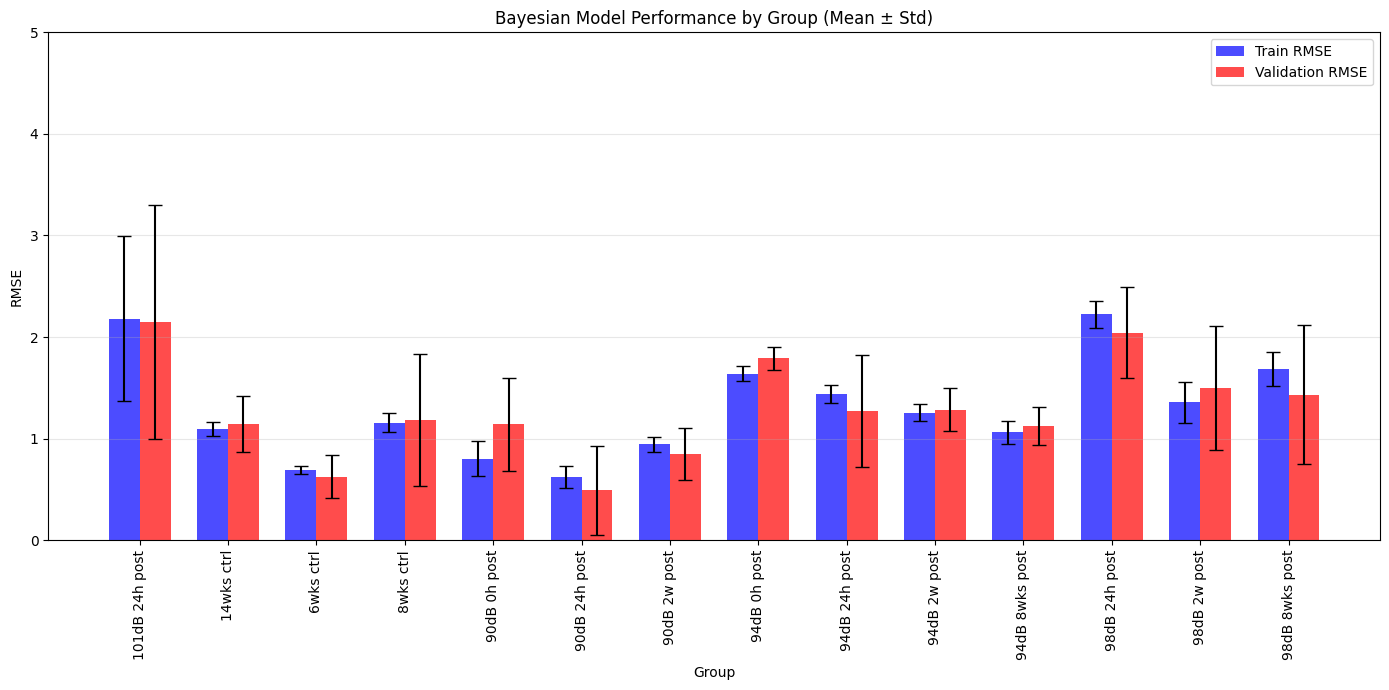

In [14]:

# Calculate average RMSE across all folds
if train_rmse_scores:
    avg_train_rmse = np.mean(train_rmse_scores)
    std_train_rmse = np.std(train_rmse_scores)
    print(f"\nAverage Train RMSE across folds: {avg_train_rmse:.4f} ± {std_train_rmse:.4f}")

if val_rmse_scores:
    avg_val_rmse = np.mean(val_rmse_scores)
    std_val_rmse = np.std(val_rmse_scores)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f} ± {std_val_rmse:.4f}")

#     print(f"{group:15s} | {train_str:25s} | {val_str:25s}")

# Visualization of group-specific RMSE
if any(group_train_rmse[group] for group in groups) and any(group_val_rmse[group] for group in groups):
    # Prepare data for plotting
    plot_groups = []
    plot_train_rmse = []
    plot_val_rmse = []
    plot_train_std = []
    plot_val_std = []
    
    for group in groups:
        if group_train_rmse[group] and group_val_rmse[group]:
            plot_groups.append(group)
            plot_train_rmse.append(np.mean(group_train_rmse[group]))
            plot_val_rmse.append(np.mean(group_val_rmse[group]))
            plot_train_std.append(np.std(group_train_rmse[group]))
            plot_val_std.append(np.std(group_val_rmse[group]))
    
    # Create plot if we have data
    if plot_groups:
        plt.figure(figsize=(14, 7))
        x = np.arange(len(plot_groups))
        width = 0.35
        
        plt.bar(x - width/2, plot_train_rmse, width, yerr=plot_train_std, 
                label='Train RMSE', color='blue', alpha=0.7, capsize=5)
        plt.bar(x + width/2, plot_val_rmse, width, yerr=plot_val_std,
                label='Validation RMSE', color='red', alpha=0.7, capsize=5)
        
        plt.xlabel('Group')
        plt.ylabel('RMSE')
        plt.ylim((0,5))
        plt.title('Bayesian Model Performance by Group (Mean ± Std)')
        plt.xticks(x, plot_groups, rotation=90)
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()


In [15]:
# Create lists to store the data
groups_list = []
train_mean_list = []
train_std_list = []
val_mean_list = []
val_std_list = []

# Extract values for each group
for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    groups_list.append(group)
    
    if train_values:
        train_mean_list.append(np.mean(train_values))
        train_std_list.append(np.std(train_values))
    else:
        train_mean_list.append(np.nan)
        train_std_list.append(np.nan)
        
    if val_values:
        val_mean_list.append(np.mean(val_values))
        val_std_list.append(np.std(val_values))
    else:
        val_mean_list.append(np.nan)
        val_std_list.append(np.nan)

group_metrics_df = pd.DataFrame({
    'Group': groups_list,
    'Train_RMSE_Mean': train_mean_list,
    'Val_RMSE_Mean': val_mean_list,
    'Train_RMSE_Std': train_std_list,
    'Val_RMSE_Std': val_std_list
})

group_metrics_df


,Group,Train_RMSE_Mean,Val_RMSE_Mean,Train_RMSE_Std,Val_RMSE_Std
0,101dB 24h post,2.181661,2.150720,0.814640,1.151244
1,14wks ctrl,1.091825,1.144009,0.068635,0.273143
2,6wks ctrl,0.689462,0.624882,0.036903,0.211427
3,8wks ctrl,1.156841,1.184417,0.091190,0.653056
4,90dB 0h post,0.802684,1.140638,0.173040,0.458889
5,90dB 24h post,0.622098,0.489889,0.104580,0.437581
6,90dB 2w post,0.945161,0.847536,0.074041,0.259266
7,94dB 0h post,1.641010,1.789897,0.071794,0.115940
8,94dB 24h post,1.438789,1.270638,0.087843,0.551312
9,94dB 2w post,1.257138,1.283364,0.085386,0.210435


In [17]:
print("\n=== FINAL TEST SET EVALUATION (Unseen Frequencies) ===")

# Create fresh subject-specific models using ALL training data (train_freqs)
final_subject_profiles = {}

for subject in X_train10['Subject'].unique():
    subject_data = X_train10[X_train10['Subject'] == subject]
    profile_key = str(subject)
    
    model = BayesianProfile_LRcompare(training_data=subject_data)
    # model = BayesianProfile_LRcompare_strain(training_data=subject_data)
    
    grouped = subject_data.groupby(['Freq(kHz) (x1)', 'Amplitude (x3)', 'Strain (x5)', 'Group'])
    for _, group_data in grouped:
        if group_data['Level(dB) (x2)'].min() < thresh:
            continue
        x1_val = group_data['Freq(kHz) (x1)'].iloc[0]
        x3_val = group_data['Amplitude (x3)'].iloc[0]
        # x5_val = group_data['Strain (x5)'].iloc[0]
        for y_val in y2_train10.loc[group_data.index]:
            model.safe_add_observation_y1(x1=x1_val, x3=x3_val, y1=float(y_val))
    
    final_subject_profiles[profile_key] = model
    print(f"✓ Trained model for Subject {subject} with {len(subject_data)} rows")

# Make predictions on the test set
test_preds = {}

for idx, row in X_test10.iterrows():
    if row['Level(dB) (x2)'] < thresh:
        continue
    subject_key = str(row['Subject'])
    if subject_key in final_subject_profiles:
        try:
            pred = final_subject_profiles[subject_key].predict_y1(
                x1=row['Freq(kHz) (x1)'], x3=row['Amplitude (x3)']
            )
            if np.isfinite(pred):
                test_preds[idx] = float(pred)
        except Exception as e:
            print(f"Prediction error at index {idx}: {e}")
            continue

# Compute overall test RMSE
if test_preds:
    y_test_true = y2_test10.loc[test_preds.keys()]
    y_test_pred = pd.Series(test_preds).reindex(y_test_true.index)
    test_rmse = np.sqrt(np.mean((y_test_true - y_test_pred) ** 2))
    test_std = np.std((y_test_true - y_test_pred))
    print(f"\n🎯 Final Test RMSE (Unseen Frequencies): {test_rmse:.4f}")
    print(f"\n📊 Test RMSE Standard Deviation: {test_std:.4f}")
else:
    print("⚠️ No valid predictions on test set.")

# Optional: Group-wise RMSE
print("\nGroup-wise RMSE (Test Set):")
for group in groups:
    mask = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[y_test_true.index, 'Group'] == group
    if mask.any():
        idx = mask[mask].index
        group_rmse = np.sqrt(np.mean((y_test_true.loc[idx] - y_test_pred.loc[idx]) ** 2))
        print(f"{group:15s} | RMSE = {group_rmse:.4f}")

# Prepare list for test RMSEs
test_rmse_list = []

# Append test RMSEs to group_metrics_df
for group in group_metrics_df['Group']:
    mask = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[y_test_true.index, 'Group'] == group
    if mask.any():
        idx = mask[mask].index
        group_rmse = np.sqrt(np.mean((y_test_true.loc[idx] - y_test_pred.loc[idx]) ** 2))
        test_rmse_list.append(group_rmse)
    else:
        test_rmse_list.append(np.nan)

# Add new column to the DataFrame
group_metrics_df['Test_RMSE_Mean'] = test_rmse_list

# Show updated DataFrame
group_metrics_df


=== FINAL TEST SET EVALUATION (Unseen Frequencies) ===
Scalers initialized with 60 records
✓ Trained model for Subject WPZ100 with 60 rows
Scalers initialized with 20 records
✓ Trained model for Subject WPZ101 with 20 rows
Scalers initialized with 62 records
✓ Trained model for Subject WPZ102 with 62 rows
Scalers initialized with 68 records
✓ Trained model for Subject WPZ103 with 68 rows
Scalers initialized with 70 records
✓ Trained model for Subject WPZ104 with 70 rows
Scalers initialized with 56 records
✓ Trained model for Subject WPZ105 with 56 rows
Scalers initialized with 64 records
✓ Trained model for Subject WPZ106 with 64 rows
Scalers initialized with 44 records
✓ Trained model for Subject WPZ107 with 44 rows
Scalers initialized with 32 records
✓ Trained model for Subject WPZ108 with 32 rows
Scalers initialized with 62 records
✓ Trained model for Subject WPZ112 with 62 rows
Scalers initialized with 62 records
✓ Trained model for Subject WPZ113 with 62 rows
Scalers initialized 

,Group,Train_RMSE_Mean,Val_RMSE_Mean,Train_RMSE_Std,Val_RMSE_Std,Test_RMSE_Mean
0,101dB 24h post,2.181661,2.150720,0.814640,1.151244,2.472169
1,14wks ctrl,1.091825,1.144009,0.068635,0.273143,2.348354
2,6wks ctrl,0.689462,0.624882,0.036903,0.211427,2.017211
3,8wks ctrl,1.156841,1.184417,0.091190,0.653056,3.309170
4,90dB 0h post,0.802684,1.140638,0.173040,0.458889,1.655694
5,90dB 24h post,0.622098,0.489889,0.104580,0.437581,2.691875
6,90dB 2w post,0.945161,0.847536,0.074041,0.259266,2.191287
7,94dB 0h post,1.641010,1.789897,0.071794,0.115940,5.009980
8,94dB 24h post,1.438789,1.270638,0.087843,0.551312,5.660540
9,94dB 2w post,1.257138,1.283364,0.085386,0.210435,2.870728


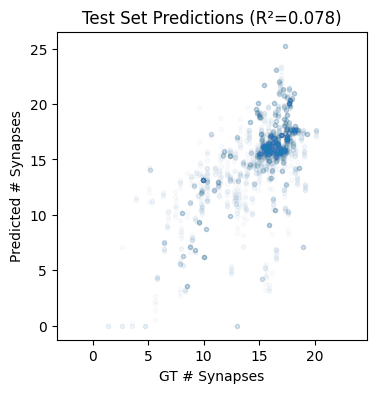

In [18]:
plt.figure(figsize=(4, 4))
plt.plot(y_test_true, y_test_pred, '.', alpha=0.01)
plt.ylim([0, 30])
plt.xlim([0, 30])
plt.axis('equal')
plt.xlabel('GT # Synapses')
plt.ylabel('Predicted # Synapses')

# calculate R^2
ss_res = np.sum((y_test_true - y_test_pred) ** 2)
ss_tot = np.sum((y_test_true - np.mean(y_test_true)) ** 2)
r2 = 1 - (ss_res / ss_tot)
plt.title(f'Test Set Predictions (R²={r2:.3f})')
plt.show()


In [19]:
print("\n=== FINAL TEST SET EVALUATION (Unseen Frequencies) ===")

# Create fresh subject-specific models using ALL training data (train_freqs)
final_subject_profiles = {}

for subject in X_train10['Subject'].unique():
    subject_data = X_train10[X_train10['Subject'] == subject]
    profile_key = str(subject)
    
    model = BayesianProfile_LRcompare(training_data=subject_data)
    # model = BayesianProfile_LRcompare_strain(training_data=subject_data)
    
    grouped = subject_data.groupby(['Freq(kHz) (x1)', 'Amplitude (x3)', 'Strain (x5)', 'Group'])
    for _, group_data in grouped:
        if group_data['Level(dB) (x2)'].min() < thresh:
            continue
        x1_val = group_data['Freq(kHz) (x1)'].iloc[0]
        x3_val = group_data['Amplitude (x3)'].iloc[0]
        # x5_val = group_data['Strain (x5)'].iloc[0]
        for y_val in y2_train10.loc[group_data.index]:
            model.safe_add_observation_y1(x1=x1_val, x3=x3_val, y1=float(y_val))
    
    final_subject_profiles[profile_key] = model
    print(f"✓ Trained model for Subject {subject} with {len(subject_data)} rows")

# Make predictions on the test set
test_preds = {}

for idx, row in X_test10.iterrows():
    if row['Level(dB) (x2)'] < thresh:
        continue
    subject_key = str(row['Subject'])
    if subject_key in final_subject_profiles:
        try:
            pred = final_subject_profiles[subject_key].predict_y1(
                x1=row['Freq(kHz) (x1)'], x3=row['Amplitude (x3)']
            )
            if np.isfinite(pred):
                test_preds[idx] = float(pred)
        except Exception as e:
            print(f"Prediction error at index {idx}: {e}")
            continue

# Compute overall test RMSE
if test_preds:
    y_test_true = y2_test10.loc[test_preds.keys()]
    y_test_pred = pd.Series(test_preds).reindex(y_test_true.index)
    test_rmse = np.sqrt(np.mean((y_test_true - y_test_pred) ** 2))
    test_std = np.std((y_test_true - y_test_pred))
    print(f"\n🎯 Final Test RMSE (Unseen Frequencies): {test_rmse:.4f}")
    print(f"\n📊 Test RMSE Standard Deviation: {test_std:.4f}")
else:
    print("⚠️ No valid predictions on test set.")

# Optional: Group-wise RMSE
print("\nGroup-wise RMSE (Test Set):")
for group in groups:
    mask = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[y_test_true.index, 'Group'] == group
    if mask.any():
        idx = mask[mask].index
        group_rmse = np.sqrt(np.mean((y_test_true.loc[idx] - y_test_pred.loc[idx]) ** 2))
        print(f"{group:15s} | RMSE = {group_rmse:.4f}")

# Prepare list for test RMSEs
test_rmse_list = []
test_rmse_std_list = []

# Append test RMSEs to group_metrics_df
for group in group_metrics_df['Group']:
    mask = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[y_test_true.index, 'Group'] == group
    if mask.any():
        idx = mask[mask].index
        group_rmse = np.sqrt(np.mean((y_test_true.loc[idx] - y_test_pred.loc[idx]) ** 2))
        group_std = np.std((y_test_true - y_test_pred))
        test_rmse_list.append(group_rmse)
        test_rmse_std_list.append(group_std)
    else:
        test_rmse_list.append(np.nan)
        test_rmse_std_list.append(np.nan)

# Add new column to the DataFrame
group_metrics_df['Test_RMSE_Mean'] = test_rmse_list
group_metrics_df['Test_RMSE_Std'] = test_rmse_std_list
# Show updated DataFrame
group_metrics_df


=== FINAL TEST SET EVALUATION (Unseen Frequencies) ===
Scalers initialized with 60 records
✓ Trained model for Subject WPZ100 with 60 rows
Scalers initialized with 20 records
✓ Trained model for Subject WPZ101 with 20 rows
Scalers initialized with 62 records
✓ Trained model for Subject WPZ102 with 62 rows
Scalers initialized with 68 records
✓ Trained model for Subject WPZ103 with 68 rows
Scalers initialized with 70 records
✓ Trained model for Subject WPZ104 with 70 rows
Scalers initialized with 56 records
✓ Trained model for Subject WPZ105 with 56 rows
Scalers initialized with 64 records
✓ Trained model for Subject WPZ106 with 64 rows
Scalers initialized with 44 records
✓ Trained model for Subject WPZ107 with 44 rows
Scalers initialized with 32 records
✓ Trained model for Subject WPZ108 with 32 rows
Scalers initialized with 62 records
✓ Trained model for Subject WPZ112 with 62 rows
Scalers initialized with 62 records
✓ Trained model for Subject WPZ113 with 62 rows
Scalers initialized 

,Group,Train_RMSE_Mean,Val_RMSE_Mean,Train_RMSE_Std,Val_RMSE_Std,Test_RMSE_Mean,Test_RMSE_Std
0,101dB 24h post,2.181661,2.150720,0.814640,1.151244,2.472169,2.931297
1,14wks ctrl,1.091825,1.144009,0.068635,0.273143,2.348354,2.931297
2,6wks ctrl,0.689462,0.624882,0.036903,0.211427,2.017211,2.931297
3,8wks ctrl,1.156841,1.184417,0.091190,0.653056,3.309170,2.931297
4,90dB 0h post,0.802684,1.140638,0.173040,0.458889,1.655694,2.931297
5,90dB 24h post,0.622098,0.489889,0.104580,0.437581,2.691875,2.931297
6,90dB 2w post,0.945161,0.847536,0.074041,0.259266,2.191287,2.931297
7,94dB 0h post,1.641010,1.789897,0.071794,0.115940,5.009980,2.931297
8,94dB 24h post,1.438789,1.270638,0.087843,0.551312,5.660540,2.931297
9,94dB 2w post,1.257138,1.283364,0.085386,0.210435,2.870728,2.931297


In [20]:
custom_group_order = [
    '6wks ctrl',
    '8wks ctrl',
    '14wks ctrl',
    '90dB 0h post',
    '90dB 24h post',
    '90dB 2w post',
    '94dB 0h post',
    '94dB 24h post',
    '94dB 2w post',
    '94dB 8wks post',
    '98dB 24h post',
    '98dB 2w post',
    '98dB 8wks post',
    '101dB 24h post',
]

# Reindex results_df to follow the custom group order
group_metrics_df_sorted = group_metrics_df.set_index('Group').reindex(custom_group_order).reset_index()
group_metrics_df_sorted[['Group','Train_RMSE_Mean', 'Test_RMSE_Mean']]


,Group,Train_RMSE_Mean,Test_RMSE_Mean
0,6wks ctrl,0.689462,2.017211
1,8wks ctrl,1.156841,3.309170
2,14wks ctrl,1.091825,2.348354
3,90dB 0h post,0.802684,1.655694
4,90dB 24h post,0.622098,2.691875
5,90dB 2w post,0.945161,2.191287
6,94dB 0h post,1.641010,5.009980
7,94dB 24h post,1.438789,5.660540
8,94dB 2w post,1.257138,2.870728
9,94dB 8wks post,1.062920,2.155354


NameError: name 'Patch' is not defined

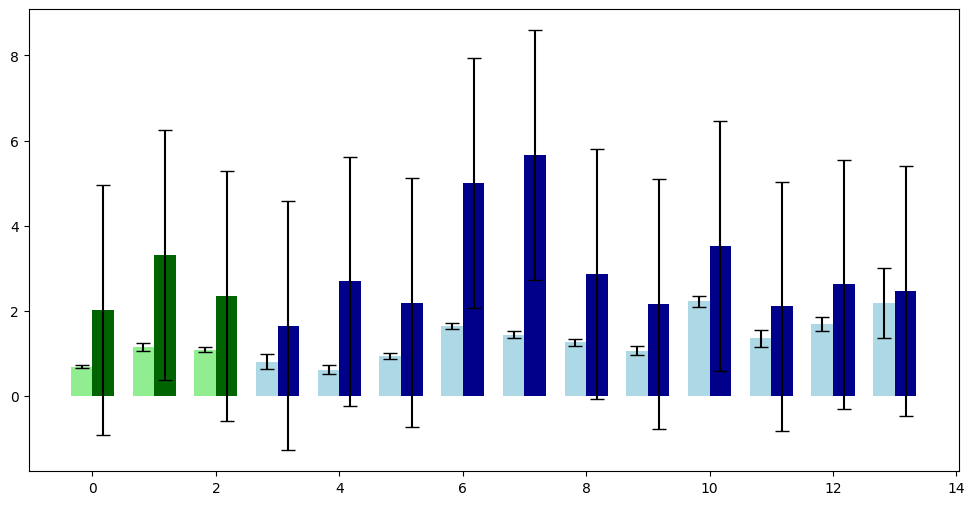

In [21]:


train_mean_col = "Train_RMSE_Mean"
train_std_col = "Train_RMSE_Std"
val_mean_col = "Val_RMSE_Mean"
val_std_col = "Val_RMSE_Std"
test_mean_col = "Test_RMSE_Mean"
test_std_col = "Test_RMSE_Std"

labels = group_metrics_df_sorted['Group']
x = np.arange(len(labels))
width = 0.35

# Define color palette (light = train, dark = val)
color_map = {
    'ctrl_train': '#90EE90',   # Light Green
    'ctrl_val':   '#006400',   # Dark Green
    'post_train': '#ADD8E6',   # Light Blue
    'post_val':   '#00008B'    # Dark Blue
}

# Assign colors to each bar
train_colors = []
val_colors = []

for group in labels:
    if 'ctrl' in group.lower():
        train_colors.append(color_map['ctrl_train'])
        val_colors.append(color_map['ctrl_val'])
    else:
        train_colors.append(color_map['post_train'])
        val_colors.append(color_map['post_val'])

fig, ax = plt.subplots(figsize=(12, 6))

# Plot Train RMSE bars
ax.bar(
    x - width/2,
    group_metrics_df_sorted[train_mean_col],
    width,
    yerr=group_metrics_df_sorted[train_std_col],
    capsize=5,
    color=train_colors
)

# # Plot Val RMSE bars
# ax.bar(
#     x + width/2,
#     group_metrics_df_sorted[val_mean_col],
#     width,
#     yerr=group_metrics_df_sorted[val_std_col],
#     capsize=5,
#     color=val_colors
# )

# Plot Test RMSE bars
ax.bar(
    x + width/2,
    group_metrics_df_sorted[test_mean_col],
    width,
    yerr=group_metrics_df_sorted[test_std_col],
    capsize=5,
    color=val_colors
)

# Custom legend
legend_patches = [
    Patch(facecolor=color_map['ctrl_train'], label='Train RMSE (Control)'),
    Patch(facecolor=color_map['ctrl_val'], label='Test RMSE (Control)'),
    Patch(facecolor=color_map['post_train'], label='Train RMSE (Experimental)'),
    Patch(facecolor=color_map['post_val'], label='Test RMSE (Experimental)')
]

ax.legend(handles=legend_patches, loc='best')
ax.set_ylabel("RMSE")
ax.set_title(" Bayesian Profile Model - RMSE per Experimental Group with Error Bars")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()


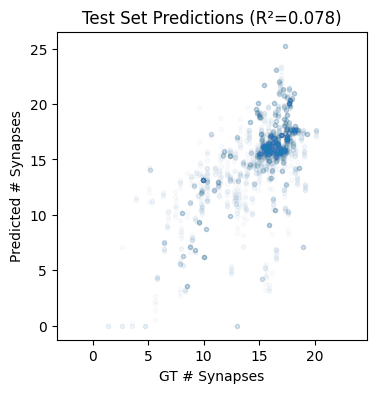

In [22]:
plt.figure(figsize=(4, 4))
plt.plot(y_test_true, y_test_pred, '.', alpha=0.01)
plt.ylim([0, 30])
plt.xlim([0, 30])
plt.axis('equal')
plt.xlabel('GT # Synapses')
plt.ylabel('Predicted # Synapses')

# calculate R^2
ss_res = np.sum((y_test_true - y_test_pred) ** 2)
ss_tot = np.sum((y_test_true - np.mean(y_test_true)) ** 2)
r2 = 1 - (ss_res / ss_tot)
plt.title(f'Test Set Predictions (R²={r2:.3f})')
plt.show()


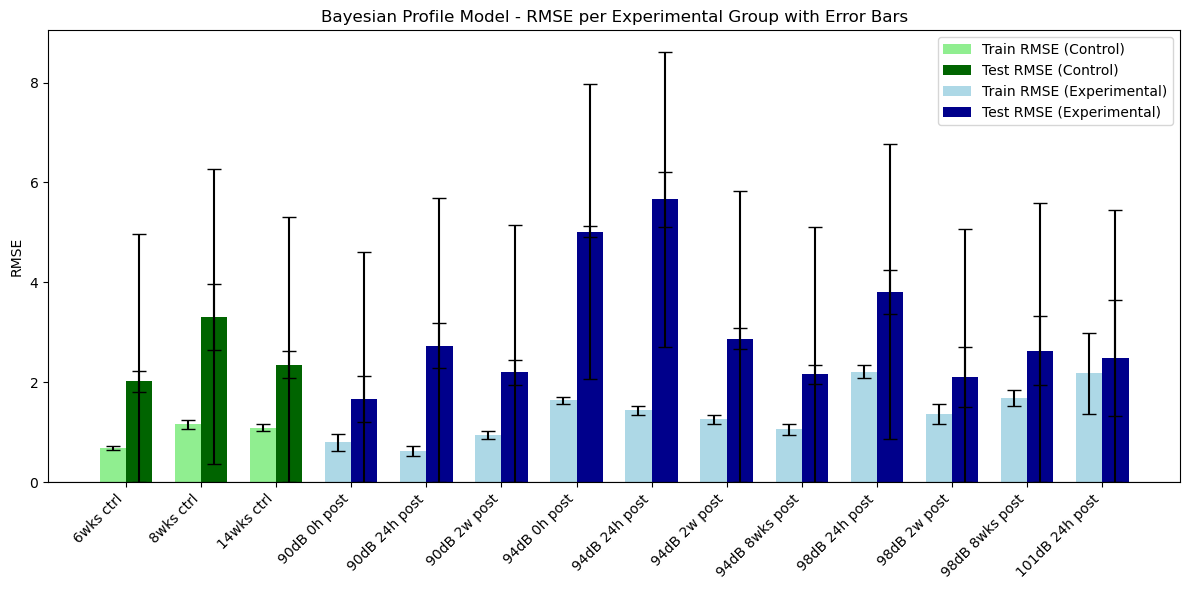

In [ ]:
train_mean_col = "Train_RMSE_Mean"
train_std_col = "Train_RMSE_Std"
val_mean_col = "Val_RMSE_Mean"
val_std_col = "Val_RMSE_Std"
test_mean_col = "Test_RMSE_Mean"
test_std_col = "Test_RMSE_Std"

labels = group_metrics_df_sorted['Group']
x = np.arange(len(labels))
width = 0.35

# Define color palette (light = train, dark = val)
color_map = {
    'ctrl_train': '#90EE90',   # Light Green
    'ctrl_val':   '#006400',   # Dark Green
    'post_train': '#ADD8E6',   # Light Blue
    'post_val':   '#00008B'    # Dark Blue
}

# Assign colors to each bar
train_colors = []
val_colors = []

for group in labels:
    if 'ctrl' in group.lower():
        train_colors.append(color_map['ctrl_train'])
        val_colors.append(color_map['ctrl_val'])
    else:
        train_colors.append(color_map['post_train'])
        val_colors.append(color_map['post_val'])

# Helper to make asymmetric error bars clipped at 0
def make_asymmetric_errors(means, stds):
    lower = np.minimum(means, stds)  # clip at 0
    upper = stds
    return [lower, upper]

# Compute error bars
train_yerr = make_asymmetric_errors(group_metrics_df_sorted[train_mean_col], group_metrics_df_sorted[train_std_col])
# val_yerr = make_asymmetric_errors(group_metrics_df_sorted[val_mean_col], group_metrics_df_sorted[val_std_col])
test_yerr = make_asymmetric_errors(group_metrics_df_sorted[test_mean_col], group_metrics_df_sorted[test_std_col])

fig, ax = plt.subplots(figsize=(12, 6))

# Plot Train RMSE bars
ax.bar(
    x - width/2,
    group_metrics_df_sorted[train_mean_col],
    width,
    yerr=train_yerr,
    capsize=5,
    color=train_colors
)

# Plot Val RMSE bars
ax.bar(
    x + width/2,
    group_metrics_df_sorted[test_mean_col],
    width,
    yerr=val_yerr,
    capsize=5,
    color=val_colors
)

# Plot Val RMSE bars
ax.bar(
    x + width/2,
    group_metrics_df_sorted[test_mean_col],
    width,
    yerr=test_yerr,
    capsize=5,
    color=val_colors
)

# Custom legend
legend_patches = [
    Patch(facecolor=color_map['ctrl_train'], label='Train RMSE (Control)'),
    Patch(facecolor=color_map['ctrl_val'], label='Test RMSE (Control)'),
    Patch(facecolor=color_map['post_train'], label='Train RMSE (Experimental)'),
    Patch(facecolor=color_map['post_val'], label='Test RMSE (Experimental)')
]

ax.legend(handles=legend_patches, loc='best')
ax.set_ylabel("RMSE")
ax.set_title("Bayesian Profile Model - RMSE per Experimental Group with Error Bars")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.axhline(0, color='black', linewidth=0.8)  # Optional: add y=0 line
plt.tight_layout()
plt.show()


In [79]:
# TESTING ON PREVIOUSLY TRAINED SUBJECT MODELS

print("\n=== GENERALIZATION EVALUATION: Unseen Frequencies for Existing Subjects ===")

test_preds_generalization = {}

for idx, row in X_test10.iterrows():
    if row['Level(dB) (x2)'] < thresh:
        continue
    
    subject_key = str(row['Subject'])
    
    if subject_key in subjects_profiles_CVsplit_LR:
        try:
            pred = subjects_profiles_CVsplit_LR[subject_key].predict_y1(
                x1=row['Freq(kHz) (x1)'], 
                x3=row['Amplitude (x3)'],
                x5=row['Strain (x5)']
            )
            if np.isfinite(pred):
                test_preds_generalization[idx] = float(pred)
        except Exception as e:
            print(f"Prediction error for subject {subject_key} at index {idx}: {e}")

# ✅ Compute overall RMSE for generalization to unseen frequencies
if test_preds_generalization:
    y_test_true = y2_test10.loc[test_preds_generalization.keys()]
    y_test_pred = pd.Series(test_preds_generalization).reindex(y_test_true.index)
    
    generalization_rmse = np.sqrt(np.mean((y_test_true - y_test_pred) ** 2))
    print(f"\n📊 Generalization RMSE (Unseen Frequencies for Existing Subjects): {generalization_rmse:.4f}")
else:
    print("⚠️ No valid predictions were made for generalization evaluation.")

# ✅ Optional: Group-wise RMSE on generalization task
print("\nGroup-wise RMSE (Unseen Frequencies, Existing Subjects):")
for group in groups:
    mask = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[y_test_true.index, 'Group'] == group
    if mask.any():
        idx = mask[mask].index
        group_rmse = np.sqrt(np.mean((y_test_true.loc[idx] - y_test_pred.loc[idx]) ** 2))
        print(f"{group:15s} | RMSE = {group_rmse:.4f}")



=== GENERALIZATION EVALUATION: Unseen Frequencies for Existing Subjects ===
Prediction error for subject WPZ100 at index 6591: predict_y1() got an unexpected keyword argument 'x5'
Prediction error for subject WPZ100 at index 6591: predict_y1() got an unexpected keyword argument 'x5'
Prediction error for subject WPZ100 at index 6591: predict_y1() got an unexpected keyword argument 'x5'
Prediction error for subject WPZ100 at index 6591: predict_y1() got an unexpected keyword argument 'x5'
Prediction error for subject WPZ100 at index 6592: predict_y1() got an unexpected keyword argument 'x5'
Prediction error for subject WPZ100 at index 6592: predict_y1() got an unexpected keyword argument 'x5'
Prediction error for subject WPZ100 at index 6592: predict_y1() got an unexpected keyword argument 'x5'
Prediction error for subject WPZ100 at index 6592: predict_y1() got an unexpected keyword argument 'x5'
Prediction error for subject WPZ100 at index 6593: predict_y1() got an unexpected keyword a

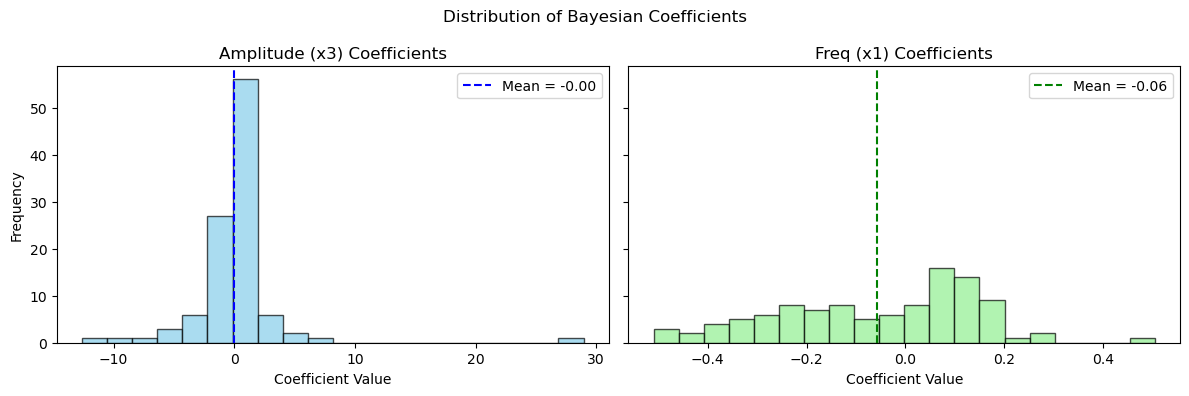

In [ ]:
all_models = [subjects_profiles_CVsplit_LR[profile_key] for profile_key in subjects_profiles_CVsplit_LR.keys()]

amplitude_coefs = []
frequency_coefs = []

for model in all_models:  # all_models = list of BayesianProfile_LRcompare instances
    amplitude_coefs.append(model.mean_y1[2])  # x3
    frequency_coefs.append(model.mean_y1[1])  # x1


# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Prepare DataFrame for seaborn
# df = pd.DataFrame({
#     'Amplitude (x3)': amplitude_coefs,
#     'Freq (x1)': frequency_coefs
# })
# df_melted = df.melt(var_name='Predictor', value_name='Coefficient')

# # Plot
# plt.figure(figsize=(6, 4))
# sns.violinplot(x='Predictor', y='Coefficient', data=df_melted, inner='box', linewidth=1, palette='Blues')

# plt.title("Distribution of Scaled Coefficients")
# plt.xlabel("Predictor")
# plt.ylabel("Coefficient Value")
# plt.tight_layout()
# plt.show()


# Assume you already collected these
# amplitude_coefs = [model.mean_y1[2] for model in all_models]
# frequency_coefs = [model.mean_y1[1] for model in all_models]

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Amplitude (x3)
ax[0].hist(amplitude_coefs, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax[0].axvline(np.mean(amplitude_coefs), color='blue', linestyle='--', label=f"Mean = {np.mean(amplitude_coefs):.2f}")
ax[0].set_title("Amplitude (x3) Coefficients")
ax[0].set_xlabel("Coefficient Value")
ax[0].set_ylabel("Frequency")
ax[0].legend()

# Frequency (x1)
ax[1].hist(frequency_coefs, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
ax[1].axvline(np.mean(frequency_coefs), color='green', linestyle='--', label=f"Mean = {np.mean(frequency_coefs):.2f}")
ax[1].set_title("Freq (x1) Coefficients")
ax[1].set_xlabel("Coefficient Value")
ax[1].legend()

plt.suptitle("Distribution of Bayesian Coefficients")
plt.tight_layout()
plt.show()



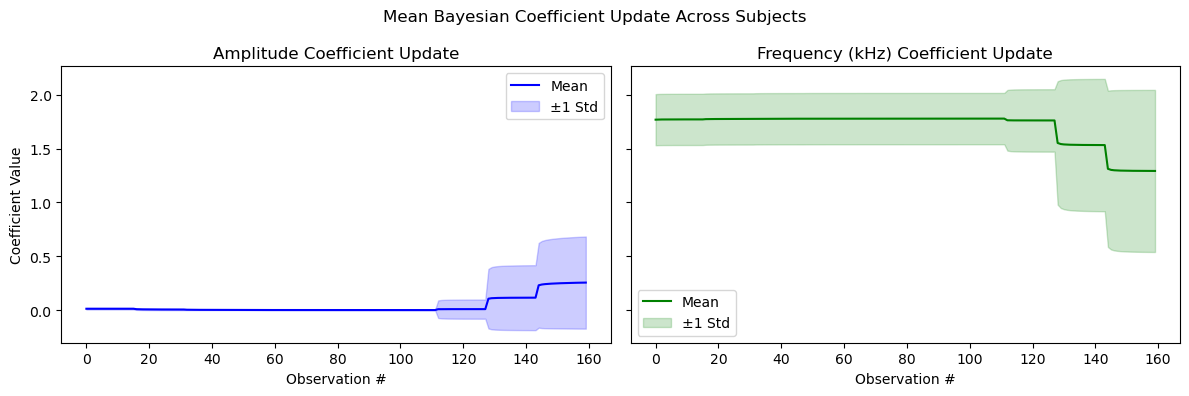

In [ ]:


# all_models = list of trained BayesianProfile_LRcompare instances
# with .coefficient_trajectory_y1 populated

# First, align all trajectories by truncating to the minimum length
min_len = min(len(m.coefficient_trajectory_y1) for m in all_models)

# Stack aligned coefficient arrays → shape: (num_models, min_len, num_coeffs)
trajectories = np.array([
    np.array(m.coefficient_trajectory_y1[:min_len])
    for m in all_models
])

# Mean and std over models
mean_traj = trajectories.mean(axis=0)     # shape: (min_len, num_coeffs)
std_traj = trajectories.std(axis=0)       # shape: (min_len, num_coeffs)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
x = np.arange(min_len)

# Amplitude (x3) – index 2
ax[0].plot(x, mean_traj[:, 2], color='blue', label='Mean')
ax[0].fill_between(x, mean_traj[:, 2] - std_traj[:, 2], mean_traj[:, 2] + std_traj[:, 2],
                   color='blue', alpha=0.2, label='±1 Std')
ax[0].set_title("Amplitude Coefficient Update")
ax[0].set_xlabel("Observation #")
ax[0].set_ylabel("Coefficient Value")
ax[0].legend()

# Frequency (x1) – index 1
ax[1].plot(x, mean_traj[:, 1], color='green', label='Mean')
ax[1].fill_between(x, mean_traj[:, 1] - std_traj[:, 1], mean_traj[:, 1] + std_traj[:, 1],
                   color='green', alpha=0.2, label='±1 Std')
ax[1].set_title("Frequency (kHz) Coefficient Update")
ax[1].set_xlabel("Observation #")
ax[1].legend()

plt.suptitle("Mean Bayesian Coefficient Update Across Subjects")
plt.tight_layout()
plt.show()


## vx based prediction

In [ ]:
# Split data based on ABR recording frequencies and compare!!!!!!!
# Because it doesn't make sense to have TT by subject for this given one model is specific to a subject...
np.random.seed(42)
groups = np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'])
sorted_freqs = sorted(np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed['Freq(kHz) (x1)']))

freq_groups = {}
for i, freq in enumerate(sorted_freqs):
    # Splits up the frequencies into n groups
    group_idx = i % 3
    if group_idx not in freq_groups:
        freq_groups[group_idx] = []
    freq_groups[group_idx].append(freq)

print(freq_groups)

recs_by_group = {}
for group in final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'].unique():
    recs_in_group = final_clean_strained_grouped_pos_cleangroup_vs_timed[final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'] == group]
    recs_by_group[group] = recs_in_group

train_freqs = []
test_freqs = []

for group_idx, freqs in freq_groups.items():
    # Shuffle frequencies within this group (kinda like RF. randomly splits on which freqs to use in train/test)
    np.random.shuffle(freqs)
    
    n_test = max(1, round(len(freqs) * 0.2))  # Ensuring at least 2 frequencies are used for testing

    # Add to overall train/test sets
    test_freqs.extend(freqs[:n_test])
    train_freqs.extend(freqs[n_test:])

# train_indices = []
# test_indices = []

for group in np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed['Group']):
    group_recs = final_clean_strained_grouped_pos_cleangroup_vs_timed[final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'] == group]
    train_group_indices = group_recs[group_recs['Freq(kHz) (x1)'].isin(train_freqs)].index.tolist()
    test_group_indices = group_recs[group_recs['Freq(kHz) (x1)'].isin(test_freqs)].index.tolist()

    # test_indices.extend(test_group_indices)
    # train_indices.extend(train_group_indices)

train_indices = []
test_indices = []

for subject in np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed['Subject']):
    subject_recs = final_clean_strained_grouped_pos_cleangroup_vs_timed[final_clean_strained_grouped_pos_cleangroup_vs_timed['Subject'] == subject]

    train_subject_indices = subject_recs[subject_recs['Freq(kHz) (x1)'].isin(train_freqs)].index.tolist()
    test_subject_indices = subject_recs[subject_recs['Freq(kHz) (x1)'].isin(test_freqs)].index.tolist()

    # Ensure the subject has data in both splits
    if len(train_subject_indices) == 0 or len(test_subject_indices) == 0:
        continue  # Skip this subject to avoid leakage problems

    test_indices.extend(test_subject_indices)
    train_indices.extend(train_subject_indices)


inputs = ['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Group']
X_train10 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[train_indices, inputs]
X_test10 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[test_indices, inputs]
y1_train10 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[train_indices, 'Synapses to IHC (y1)']
y1_test10 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[test_indices, 'Synapses to IHC (y1)']

{0: [np.float64(8.0), np.float64(22.6)], 1: [np.float64(11.3), np.float64(32.0)], 2: [np.float64(16.0), np.float64(45.2)]}



Processing Fold 1
Fold 1: No successful training predictions

Processing Fold 2
Train: 1832 successful predictions out of 9552
Validation: 688 successful predictions out of 2725
Fold 2: Train RMSE = 1.6206, Validation RMSE = 1.5000
Train: 1832 successful predictions out of 9552
Validation: 688 successful predictions out of 2725
Fold 2: Train RMSE = 1.6206, Validation RMSE = 1.5000
Train: 1832 successful predictions out of 9552
Validation: 688 successful predictions out of 2725
Fold 2: Train RMSE = 1.6206, Validation RMSE = 1.5000
Train: 1832 successful predictions out of 9552
Validation: 688 successful predictions out of 2725
Fold 2: Train RMSE = 1.6206, Validation RMSE = 1.5000
Train: 1867 successful predictions out of 9552
Validation: 688 successful predictions out of 2725
Fold 2: Train RMSE = 1.6198, Validation RMSE = 1.5000
Train: 1867 successful predictions out of 9552
Validation: 688 successful predictions out of 2725
Fold 2: Train RMSE = 1.6198, Validation RMSE = 1.5000
Train: 

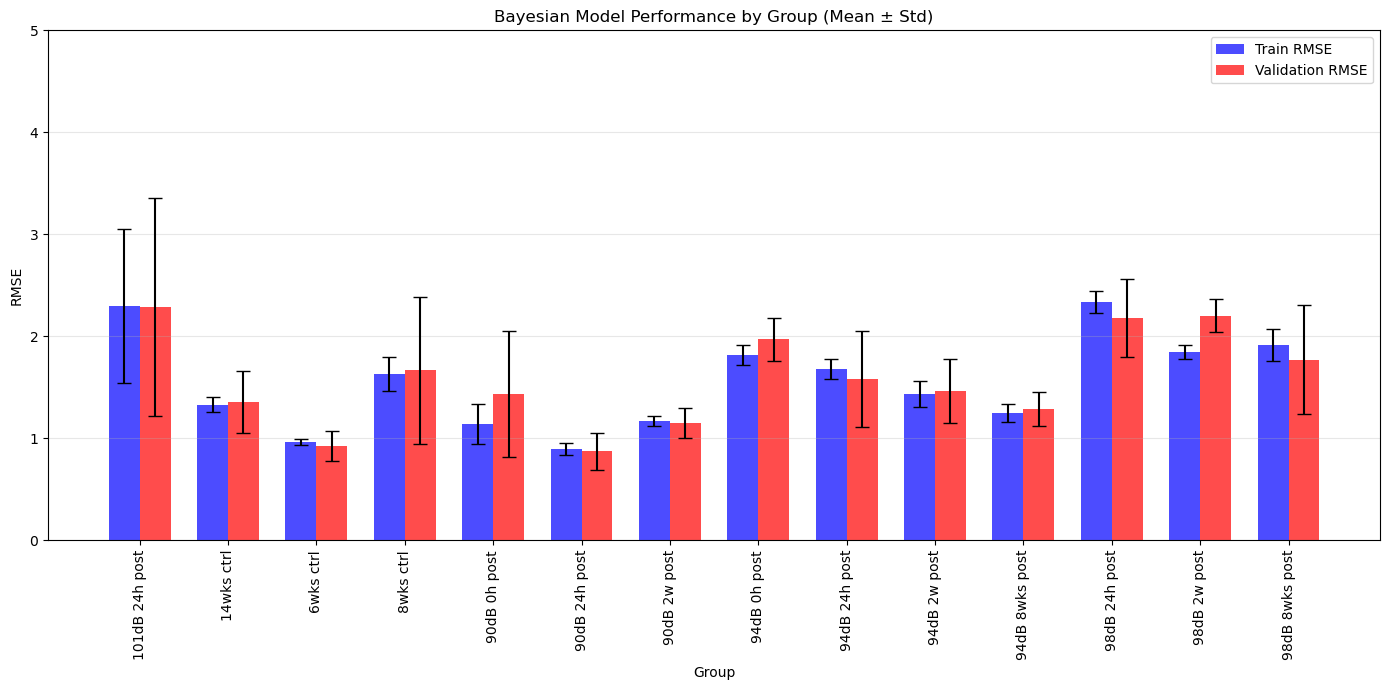

,Group,Train_RMSE_Mean,Val_RMSE_Mean,Train_RMSE_Std,Val_RMSE_Std
0,101dB 24h post,2.295377,2.284370,0.755458,1.068266
1,14wks ctrl,1.330259,1.356792,0.071198,0.304387
2,6wks ctrl,0.960201,0.922616,0.027995,0.149295
3,8wks ctrl,1.631135,1.666259,0.168918,0.720516
4,90dB 0h post,1.140579,1.434500,0.199302,0.618951
5,90dB 24h post,0.892366,0.870246,0.060655,0.181230
6,90dB 2w post,1.167443,1.149015,0.047883,0.147681
7,94dB 0h post,1.815965,1.968873,0.096823,0.207061
8,94dB 24h post,1.682407,1.576901,0.096766,0.471511
9,94dB 2w post,1.432796,1.465281,0.126411,0.315220


In [27]:
# fixed to have subjects stay within one fold

thresh = 0
# k_folds = KFold(n_splits=5, shuffle=True, random_state=42)
train_rmse_scores = []
val_rmse_scores = []
subjects_profiles_CVsplit_LR = {}
all_train_data = {}
all_val_data = {}

groups = [str(group) for group in np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'])]
group_train_rmse = {group: [] for group in groups}
group_val_rmse = {group: [] for group in groups}

group_k_fold = GroupKFold(n_splits=5, shuffle=True, random_state=42)
for fold_idx, (train_idx, val_idx) in enumerate(group_k_fold.split(X_train10, groups=X_train10['Subject'])):
    X_fold_train, X_fold_val = X_train10.iloc[train_idx], X_train10.iloc[val_idx]
    y_fold_train, y_fold_val = y1_train10.iloc[train_idx], y1_train10.iloc[val_idx]
    print(f"\nProcessing Fold {fold_idx+1}")
    
    for subject in np.unique(X_fold_train['Subject']):
        profile_key = f"{subject}"
        subjects_profiles_CVsplit_LR[profile_key] = BayesianProfile_LRcompare()
        
        subject_data = X_fold_train[X_fold_train['Subject'] == subject]
        
        grouped = subject_data.groupby([
            'Freq(kHz) (x1)', 'Amplitude (x3)', 'Strain (x5)',   
            'Group'
        ])
        
        for group_key, group_data in grouped:
            if group_data['Level(dB) (x2)'].min() < thresh:
                continue
                
            indices = group_data.index
            y_values = y_fold_train.loc[indices]
            
            for n in range(len(group_data)):
                x1_val = group_data['Freq(kHz) (x1)'].iloc[n]
                x3_val = group_data['Amplitude (x3)'].iloc[n]
            
                for idx, y1_val in zip(indices, y_values):
                    subjects_profiles_CVsplit_LR[profile_key].add_observation_y1(
                        x1=x1_val,x3=x3_val,
                        y1=float(y1_val),
                    )
    
        train_predictions = {}
        
        for idx, row in X_fold_train.iterrows():
            if row['Level(dB) (x2)'] >= thresh:
                subject = row['Subject']
                profile_key = f"{subject}"
                x1_train = row['Freq(kHz) (x1)']
                x3_train = row['Amplitude (x3)']
            if profile_key in subjects_profiles_CVsplit_LR:
                pred = subjects_profiles_CVsplit_LR[profile_key].predict_y1(x1= x1_train, x3=x3_train)
                train_predictions[idx] = float(pred) 

        successful_train_indices = list(train_predictions.keys())
        
        if successful_train_indices:
            y_train_true = y_fold_train.loc[successful_train_indices]
            y_train_pred = pd.Series([train_predictions[idx] for idx in successful_train_indices], 
                                    index=successful_train_indices)
            
            # Do the same for validation
        val_predictions = {}
        
        for idx, row in X_fold_val.iterrows():
            if row['Level(dB) (x2)'] >= thresh:
                subject = row['Subject']
                profile_key = f"{subject}"
                x1_val = row['Freq(kHz) (x1)']
                x3_val = row['Amplitude (x3)']
            if profile_key in subjects_profiles_CVsplit_LR:
                pred = subjects_profiles_CVsplit_LR[profile_key].predict_y1(x1= x1_val, x3=x3_val)
                val_predictions[idx] = float(pred)  # Ensure it's a scalar

        
        # Create properly indexed validation predictions
            successful_val_indices = list(val_predictions.keys())
            
        if successful_val_indices:
            y_val_true = y_fold_val.loc[successful_val_indices]
            y_val_pred = pd.Series([val_predictions[idx] for idx in successful_val_indices], 
                                index=successful_val_indices)
            
            # Print basic information
            print(f"Train: {len(successful_train_indices)} successful predictions out of {len(X_fold_train)}")
            print(f"Validation: {len(successful_val_indices)} successful predictions out of {len(X_fold_val)}")
            
            # Calculate RMSE
            true_name = f'{fold_idx} - train - true'
            pred_name = f'{fold_idx} - train - pred'
            all_train_data[true_name] = y_train_true
            all_train_data[pred_name] = y_train_pred

            fold_train_rmse = np.sqrt(np.mean((y_train_true - y_train_pred)**2))
            train_rmse_scores.append(fold_train_rmse)
            
            true_name = f'{fold_idx} - val - true'
            pred_name = f'{fold_idx} - val - pred'
            all_val_data[true_name] = y_val_true
            all_val_data[pred_name] = y_val_pred

            fold_val_rmse = np.sqrt(np.mean((y_val_true - y_val_pred)**2))
            val_rmse_scores.append(fold_val_rmse)
            
            print(f"Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Validation RMSE = {fold_val_rmse:.4f}")
                    
                    # Calculate group-specific RMSE
            for group in groups:
                # Get the subject groups
                train_subjects_df = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[successful_train_indices]
                val_subjects_df = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[successful_val_indices]
                
                # Filter for successful predictions for this group
                group_train_mask = train_subjects_df['Group'] == group
                if group_train_mask.any():
                    group_indices = group_train_mask.index[group_train_mask]
                    group_rmse = np.sqrt(np.mean((y_train_true.loc[group_indices] - y_train_pred.loc[group_indices])**2))
                    group_train_rmse[group].append(group_rmse)
                
                group_val_mask = val_subjects_df['Group'] == group
                if group_val_mask.any():
                    group_indices = group_val_mask.index[group_val_mask]
                    group_rmse = np.sqrt(np.mean((y_val_true.loc[group_indices] - y_val_pred.loc[group_indices])**2))
                    group_val_rmse[group].append(group_rmse) 
    else:
        print(f"Fold {fold_idx+1}: No successful training predictions")

# Calculate average RMSE across all folds
if train_rmse_scores:
    avg_train_rmse = np.mean(train_rmse_scores)
    std_train_rmse = np.std(train_rmse_scores)
    print(f"\nAverage Train RMSE across folds: {avg_train_rmse:.4f} ± {std_train_rmse:.4f}")

if val_rmse_scores:
    avg_val_rmse = np.mean(val_rmse_scores)
    std_val_rmse = np.std(val_rmse_scores)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f} ± {std_val_rmse:.4f}")

# # Calculate group-specific RMSE 
# print("\nGroup-specific RMSE:")
# print("Group | Train RMSE (Mean ± Std) | Validation RMSE (Mean ± Std)")
# print("----- | ----------------------- | -----------------------------")
# for group in groups:
#     train_values = group_train_rmse[group]
#     val_values = group_val_rmse[group]
    
#     if train_values:
#         train_mean = np.mean(train_values)
#         train_std = np.std(train_values)
#         train_str = f"{train_mean:.6f} ± {train_std:.6f}"
#     else:
#         train_str = "N/A"
        
#     if val_values:
#         val_mean = np.mean(val_values)
#         val_std = np.std(val_values)
#         val_str = f"{val_mean:.6f} ± {val_std:.6f}"
#     else:
#         val_str = "N/A"
        
#     print(f"{group:15s} | {train_str:25s} | {val_str:25s}")

# Visualization of group-specific RMSE
if any(group_train_rmse[group] for group in groups) and any(group_val_rmse[group] for group in groups):
    # Prepare data for plotting
    plot_groups = []
    plot_train_rmse = []
    plot_val_rmse = []
    plot_train_std = []
    plot_val_std = []
    
    for group in groups:
        if group_train_rmse[group] and group_val_rmse[group]:
            plot_groups.append(group)
            plot_train_rmse.append(np.mean(group_train_rmse[group]))
            plot_val_rmse.append(np.mean(group_val_rmse[group]))
            plot_train_std.append(np.std(group_train_rmse[group]))
            plot_val_std.append(np.std(group_val_rmse[group]))
    
    # Create plot if we have data
    if plot_groups:
        plt.figure(figsize=(14, 7))
        x = np.arange(len(plot_groups))
        width = 0.35
        
        plt.bar(x - width/2, plot_train_rmse, width, yerr=plot_train_std, 
                label='Train RMSE', color='blue', alpha=0.7, capsize=5)
        plt.bar(x + width/2, plot_val_rmse, width, yerr=plot_val_std,
                label='Validation RMSE', color='red', alpha=0.7, capsize=5)
        
        plt.xlabel('Group')
        plt.ylabel('RMSE')
        plt.ylim((0,5))
        plt.title('Bayesian Model Performance by Group (Mean ± Std)')
        plt.xticks(x, plot_groups, rotation=90)
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

groups_list = []
train_mean_list = []
train_std_list = []
val_mean_list = []
val_std_list = []

# Extract values for each group
for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    groups_list.append(group)
    
    if train_values:
        train_mean_list.append(np.mean(train_values))
        train_std_list.append(np.std(train_values))
    else:
        train_mean_list.append(np.nan)
        train_std_list.append(np.nan)
        
    if val_values:
        val_mean_list.append(np.mean(val_values))
        val_std_list.append(np.std(val_values))
    else:
        val_mean_list.append(np.nan)
        val_std_list.append(np.nan)


# Create lists to store the data
groups_list = []
train_mean_list = []
train_std_list = []
val_mean_list = []
val_std_list = []

# Extract values for each group
for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    groups_list.append(group)
    
    if train_values:
        train_mean_list.append(np.mean(train_values))
        train_std_list.append(np.std(train_values))
    else:
        train_mean_list.append(np.nan)
        train_std_list.append(np.nan)
        
    if val_values:
        val_mean_list.append(np.mean(val_values))
        val_std_list.append(np.std(val_values))
    else:
        val_mean_list.append(np.nan)
        val_std_list.append(np.nan)

group_metrics_df = pd.DataFrame({
    'Group': groups_list,
    'Train_RMSE_Mean': train_mean_list,
    'Val_RMSE_Mean': val_mean_list,
    'Train_RMSE_Std': train_std_list,
    'Val_RMSE_Std': val_std_list
})

group_metrics_df

Above is testing intra-subject/model consistency. Below is testing model generalization.

In [30]:
print("\n=== FINAL TEST SET EVALUATION (Unseen Frequencies) ===")

# Create fresh subject-specific models using ALL training data (train_freqs)
final_subject_profiles = {}

for subject in X_train10['Subject'].unique():
    subject_data = X_train10[X_train10['Subject'] == subject]
    profile_key = str(subject)
    
    model = BayesianProfile_LRcompare(training_data=subject_data)
    
    grouped = subject_data.groupby(['Freq(kHz) (x1)', 'Amplitude (x3)', 'Strain (x5)', 'Group'])
    for _, group_data in grouped:
        if group_data['Level(dB) (x2)'].min() < thresh:
            continue
        x1_val = group_data['Freq(kHz) (x1)'].iloc[0]
        x3_val = group_data['Amplitude (x3)'].iloc[0]
        for y_val in y1_train10.loc[group_data.index]:
            model.add_observation_y1(x1=x1_val, x3=x3_val, y1=float(y_val))
    
    final_subject_profiles[profile_key] = model
    print(f"✓ Trained model for Subject {subject} with {len(subject_data)} rows")

# Make predictions on the test set
test_preds = {}

for idx, row in X_test10.iterrows():
    if row['Level(dB) (x2)'] < thresh:
        continue
    subject_key = str(row['Subject'])
    if subject_key in final_subject_profiles:
        try:
            pred = final_subject_profiles[subject_key].predict_y1(
                x1=row['Freq(kHz) (x1)'], x3=row['Amplitude (x3)']
            )
            if np.isfinite(pred):
                test_preds[idx] = float(pred)
        except Exception as e:
            print(f"Prediction error at index {idx}: {e}")
            continue

# Compute overall test RMSE
if test_preds:
    y_test_true = y1_test10.loc[test_preds.keys()]
    y_test_pred = pd.Series(test_preds).reindex(y_test_true.index)
    test_rmse = np.sqrt(np.mean((y_test_true - y_test_pred) ** 2))
    print(f"\n🎯 Final Test RMSE (Unseen Frequencies): {test_rmse:.4f}")
else:
    print("⚠️ No valid predictions on test set.")

# Optional: Group-wise RMSE
print("\nGroup-wise RMSE (Test Set):")
for group in groups:
    mask = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[y_test_true.index, 'Group'] == group
    if mask.any():
        idx = mask[mask].index
        group_rmse = np.sqrt(np.mean((y_test_true.loc[idx] - y_test_pred.loc[idx]) ** 2))
        print(f"{group:15s} | RMSE = {group_rmse:.4f}")



=== FINAL TEST SET EVALUATION (Unseen Frequencies) ===
Scalers initialized with 120 records
✓ Trained model for Subject WPZ100 with 120 rows
Scalers initialized with 40 records
✓ Trained model for Subject WPZ101 with 40 rows
Scalers initialized with 124 records
✓ Trained model for Subject WPZ102 with 124 rows
Scalers initialized with 136 records
✓ Trained model for Subject WPZ103 with 136 rows
Scalers initialized with 140 records
✓ Trained model for Subject WPZ104 with 140 rows
Scalers initialized with 112 records
✓ Trained model for Subject WPZ105 with 112 rows
Scalers initialized with 128 records
✓ Trained model for Subject WPZ106 with 128 rows
Scalers initialized with 88 records
✓ Trained model for Subject WPZ107 with 88 rows
Scalers initialized with 64 records
✓ Trained model for Subject WPZ108 with 64 rows
Scalers initialized with 124 records
✓ Trained model for Subject WPZ112 with 124 rows
Scalers initialized with 124 records
✓ Trained model for Subject WPZ113 with 124 rows
Scal